In [1]:
install.packages("sandwich")
install.packages("coefplot")
install.packages("lmtest")


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcnZNLb\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'coefplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcnZNLb\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'lmtest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'lmtest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\00LOCK\lmtest\libs\x64\lmtest.dll to C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\lmtest\libs\x64\lmtest.dll: Permission denied"
Warning message:
"restored 'lmtest'"



The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcnZNLb\downloaded_packages


In [2]:
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)
library(sandwich)
library(coefplot)
library(lmtest)


Warning message:
"package 'geojsonio' was built under R version 4.4.2"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


udunits database from

In [3]:
# Read in the data
census_index_crime <- st_read("census_index_crime.geojson") |>
    mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
    na.omit()|>
    glimpse()

Reading layer `census_index_crime' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\census_index_crime.geojson' 
  using driver `GeoJSON'
Simple feature collection with 993 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -123.2242 ymin: 49.19853 xmax: -123.0229 ymax: 49.31408
Geodetic CRS:  WGS 84


Warning message:
"There were 4 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <chr> "Vancouver", "Vancouver", "Vancouver", "Vancouver…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.074675, 1.252273, 1.426336, 2.441091, 1.543095,…
$ light_index     

In [4]:
census_save <- census_index_crime|>
    st_drop_geometry()

write.csv(census_save, "census_index_crime.csv")


In [5]:
fn_residuals <- function(data, dependent_vars, independent_var) {
  
residuals_list <- list() #empty accumulator list

# looping through each variable and calcualting residuals
  for (var in dependent_vars) {
   formula <- as.formula(paste(var, "~", independent_var)) # https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/formula
    model <- lm(formula, data = data)
    residuals_list[[var]] <- resid(model) # extracting residuals and assigning to empty list
  }
  
  residuals_df <- as.data.frame(residuals_list)
  colnames(residuals_df) <- paste0("residual_", dependent_vars)

residuals_df <- cbind(residuals_df, data[dependent_vars]) |>
select(!geometry)

 return(residuals_df)
}


Rows: 989
Columns: 2
$ residual_bus_index <dbl> -1.62317900, -1.48040693, -1.12875315, 0.67312399, …
$ bus_index          <dbl> 1.314003, 1.455674, 1.812310, 3.605736, 1.782943, 1…


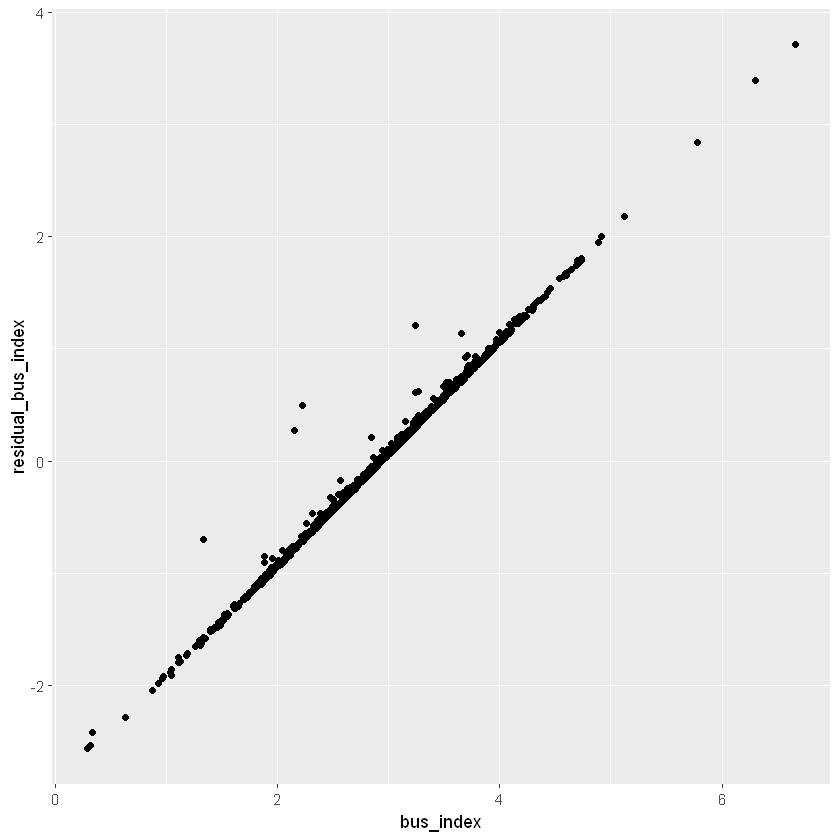

In [6]:
# test that the function works properly

residuals_bus <- fn_residuals(data = census_index_crime, dependent_var = "bus_index", independent_var = "mean_land_value")
glimpse(residuals_bus)

test_res <- residuals_bus |>
ggplot(aes(x=bus_index, y=residual_bus_index)) +geom_point()

test_res

In [7]:
dependent_vars <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, dependent_vars, "crime_rate")

In [8]:
glimpse(residuals_df)

Rows: 989
Columns: 16
$ residual_mean_land_value      <dbl> -0.9850139, -0.9110909, -1.1870712, -0.7…
$ residual_school_index         <dbl> -1.55033886, -1.36752701, -1.19754199, -…
$ residual_light_index          <dbl> -1.03450149, -1.15903864, -0.78886803, -…
$ residual_bus_index            <dbl> -1.59937960, -1.42126915, -1.09313819, 0…
$ residual_cultural_space_index <dbl> -0.92630452, -0.80803867, -0.71491957, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.074675, 1.252273, 1.426336, 2.441091, …
$ light_index                   <dbl> 2.751678, 2.575631, 2.986096, 3.239346, …
$ bus_index                     <dbl> 1.314003, 1.455674, 1.812310, 3.605736, …
$ cultural_space_i

In [9]:

residuals_long <- residuals_df |>
  pivot_longer(
    cols = starts_with("residual_"), names_to = "residual_type", values_to = "residual_value") |>
  mutate(x_value = case_when(
    residual_type == "residual_mean_land_value" ~ mean_land_value,
    residual_type == "residual_school_index" ~ school_index,
    residual_type == "residual_light_index" ~ light_index,
    residual_type == "residual_bus_index" ~ bus_index,
    residual_type == "residual_cultural_space_index" ~ cultural_space_index,
    residual_type == "residual_income" ~ income,
    residual_type == "residual_immigrant_prop" ~ immigrant_prop,
    residual_type == "residual_education_prop" ~ education_prop
  ))

In [10]:
glimpse(residuals_long)

Rows: 7,912
Columns: 11
$ mean_land_value      <dbl> 0.9556436, 0.9556436, 0.9556436, 0.9556436, 0.955…
$ school_index         <dbl> 1.074675, 1.074675, 1.074675, 1.074675, 1.074675,…
$ light_index          <dbl> 2.751678, 2.751678, 2.751678, 2.751678, 2.751678,…
$ bus_index            <dbl> 1.314003, 1.314003, 1.314003, 1.314003, 1.314003,…
$ cultural_space_index <dbl> 1.286579, 1.286579, 1.286579, 1.286579, 1.286579,…
$ income               <dbl> 0.90965, 0.90965, 0.90965, 0.90965, 0.90965, 0.90…
$ immigrant_prop       <dbl> 0.2610759, 0.2610759, 0.2610759, 0.2610759, 0.261…
$ education_prop       <dbl> 0.3085443, 0.3085443, 0.3085443, 0.3085443, 0.308…
$ residual_type        <chr> "residual_mean_land_value", "residual_school_inde…
$ residual_value       <dbl> -0.98501394, -1.55033886, -1.03450149, -1.5993796…
$ x_value              <dbl> 0.9556436, 1.0746748, 2.7516784, 1.3140034, 1.286…


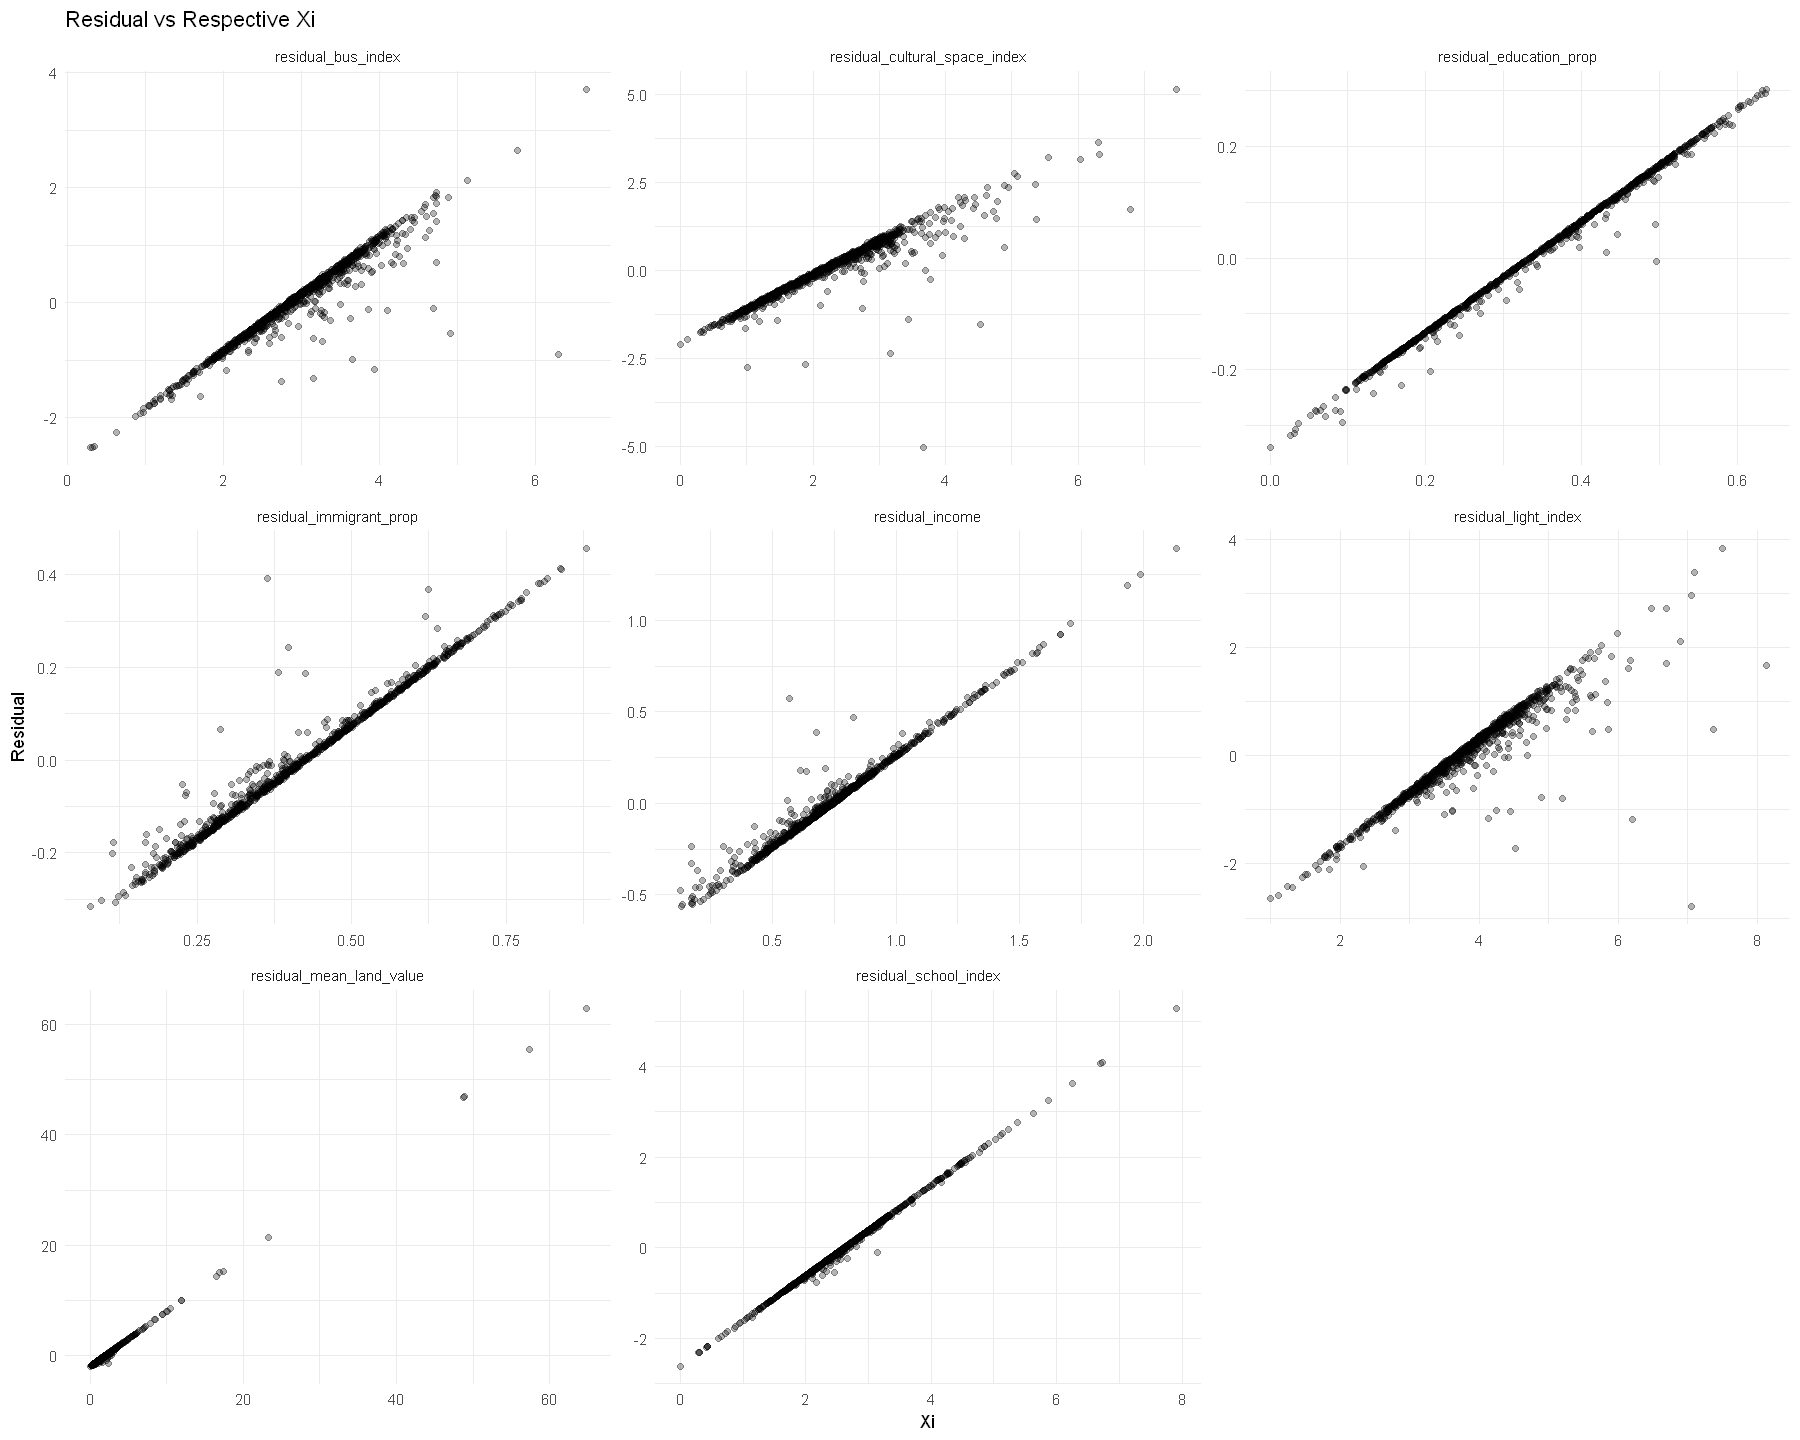

In [11]:
options(repr.plot.width = 15, repr.plot.height = 12)

residuals_plot <- ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha = 0.3) +
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual") +
  theme_minimal()

residuals_plot

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `model = list(lm(residual_value ~ x_value, data = cur_data()))`.
ℹ In group 1: `residual_type = "residual_bus_index"`.
Caused by warning:
! `cur_data()` was deprecated in dplyr 1.1.0.
ℹ Please use `pick()` instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


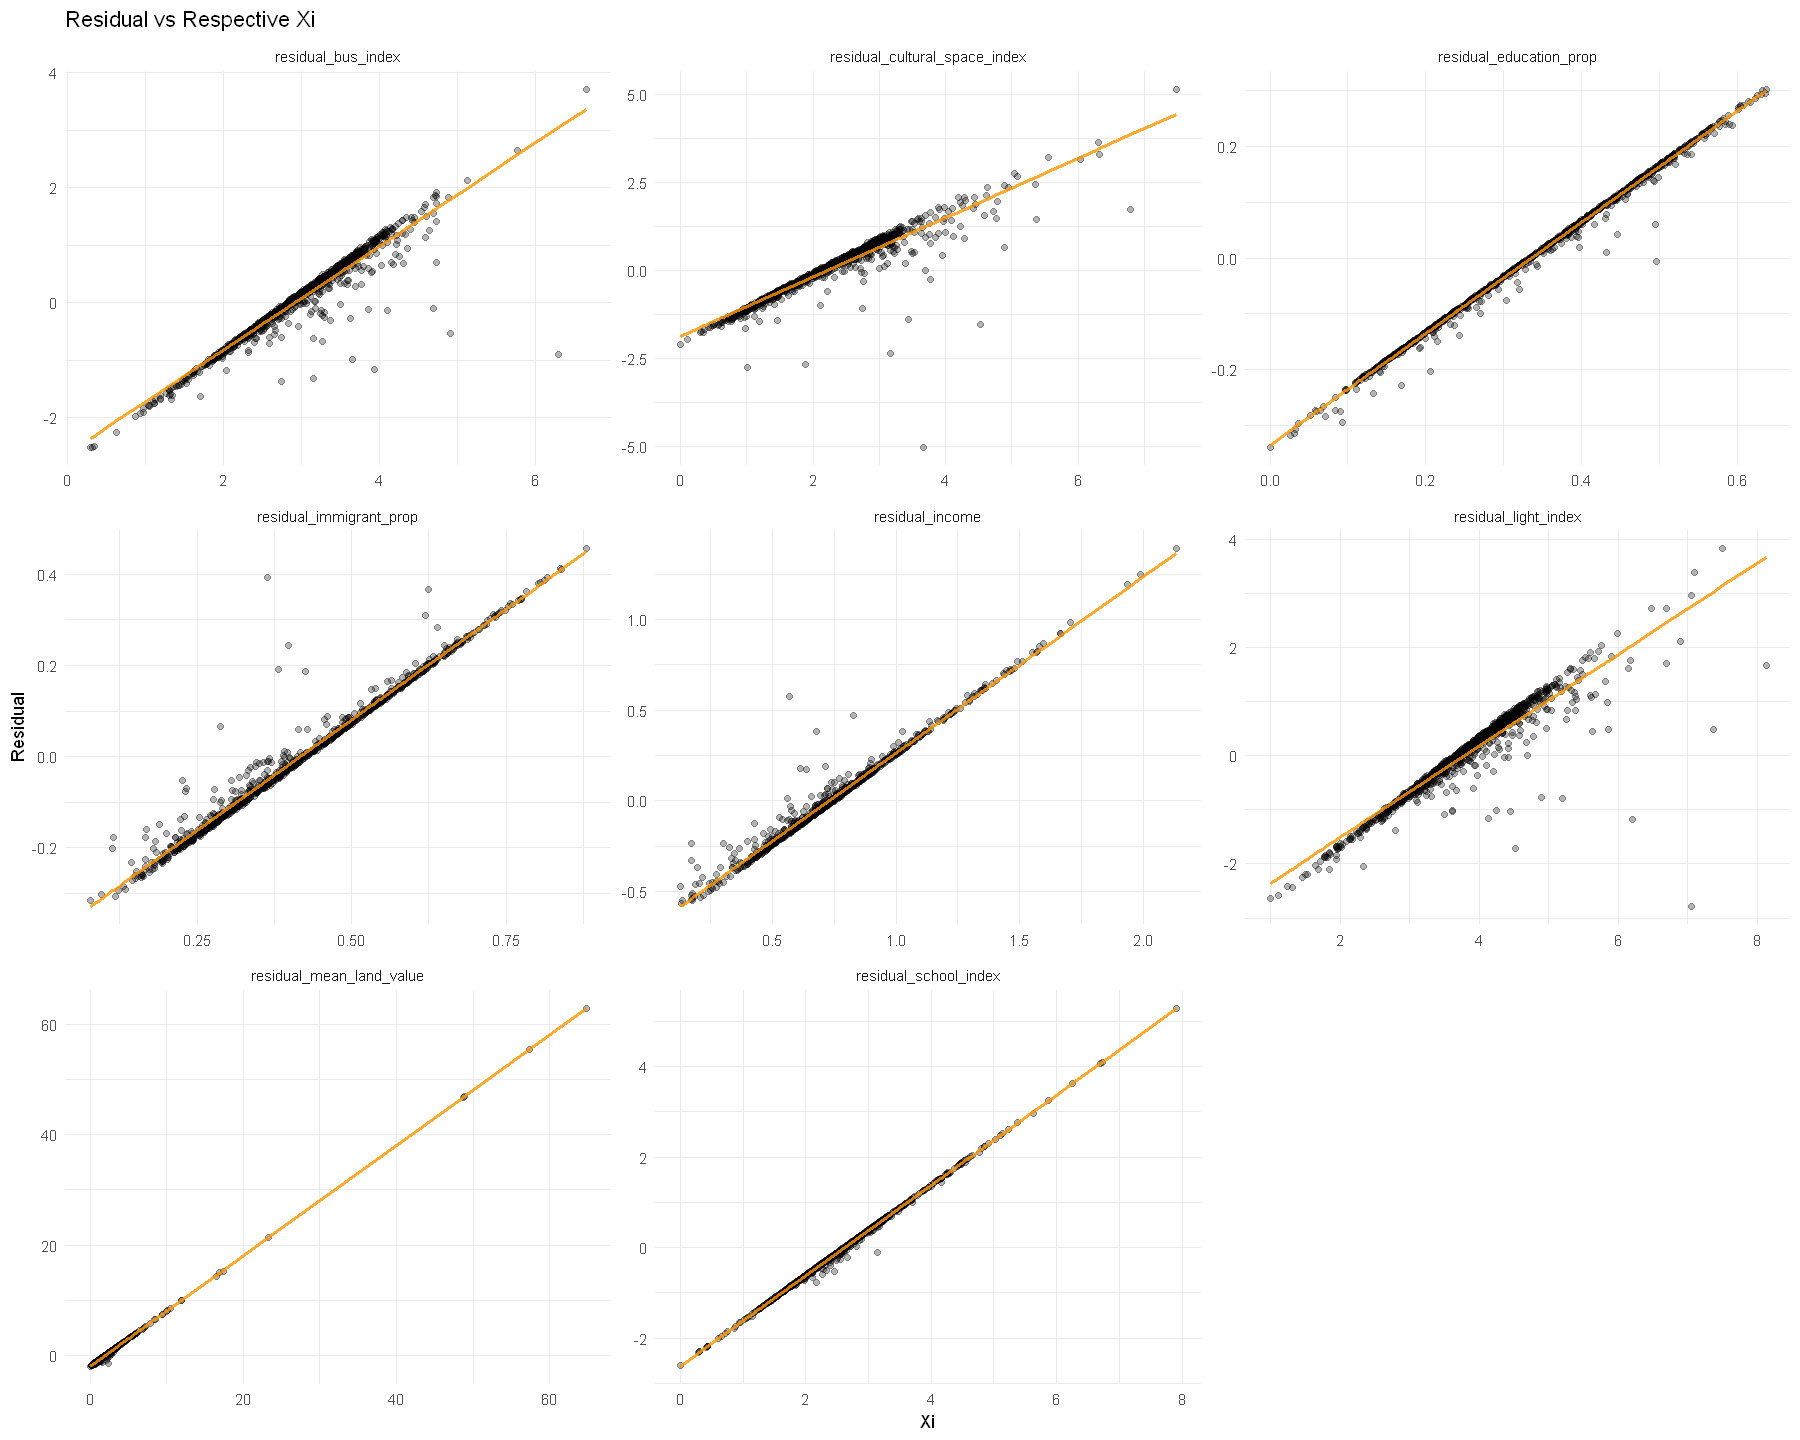

In [12]:
residuals_long  <- residuals_long |>
  group_by(residual_type) |>
  mutate(
    model = list(lm(residual_value ~ x_value, data = cur_data())),
    fitted_values = predict(model[[1]], newdata = data.frame(x_value = x_value))
  ) |>
  ungroup()

ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha=0.3) +
  geom_line(aes(y = fitted_values), color = "#ff9500", size=1, alpha=0.8) +  
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual"
  ) +
  theme_minimal()

In [13]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, regressors, "crime_rate") |>
mutate(crime_rate = census_index_crime$crime_rate) 

glimpse(residuals_df)


colnames(residuals_df)

Rows: 989
Columns: 17
$ residual_mean_land_value      <dbl> -0.9850139, -0.9110909, -1.1870712, -0.7…
$ residual_school_index         <dbl> -1.55033886, -1.36752701, -1.19754199, -…
$ residual_light_index          <dbl> -1.03450149, -1.15903864, -0.78886803, -…
$ residual_bus_index            <dbl> -1.59937960, -1.42126915, -1.09313819, 0…
$ residual_cultural_space_index <dbl> -0.92630452, -0.80803867, -0.71491957, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.074675, 1.252273, 1.426336, 2.441091, …
$ light_index                   <dbl> 2.751678, 2.575631, 2.986096, 3.239346, …
$ bus_index                     <dbl> 1.314003, 1.455674, 1.812310, 3.605736, …
$ cultural_space_i

[1] "residual_mean_land_value"      "residual_school_index"        
 [3] "residual_light_index"          "residual_bus_index"           
 [5] "residual_cultural_space_index" "residual_income"              
 [7] "residual_immigrant_prop"       "residual_education_prop"      
 [9] "mean_land_value"               "school_index"                 
[11] "light_index"                   "bus_index"                    
[13] "cultural_space_index"          "income"                       
[15] "immigrant_prop"                "education_prop"               
[17] "crime_rate"

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors)

  # Now:
  data %>% select(all_of(regressors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


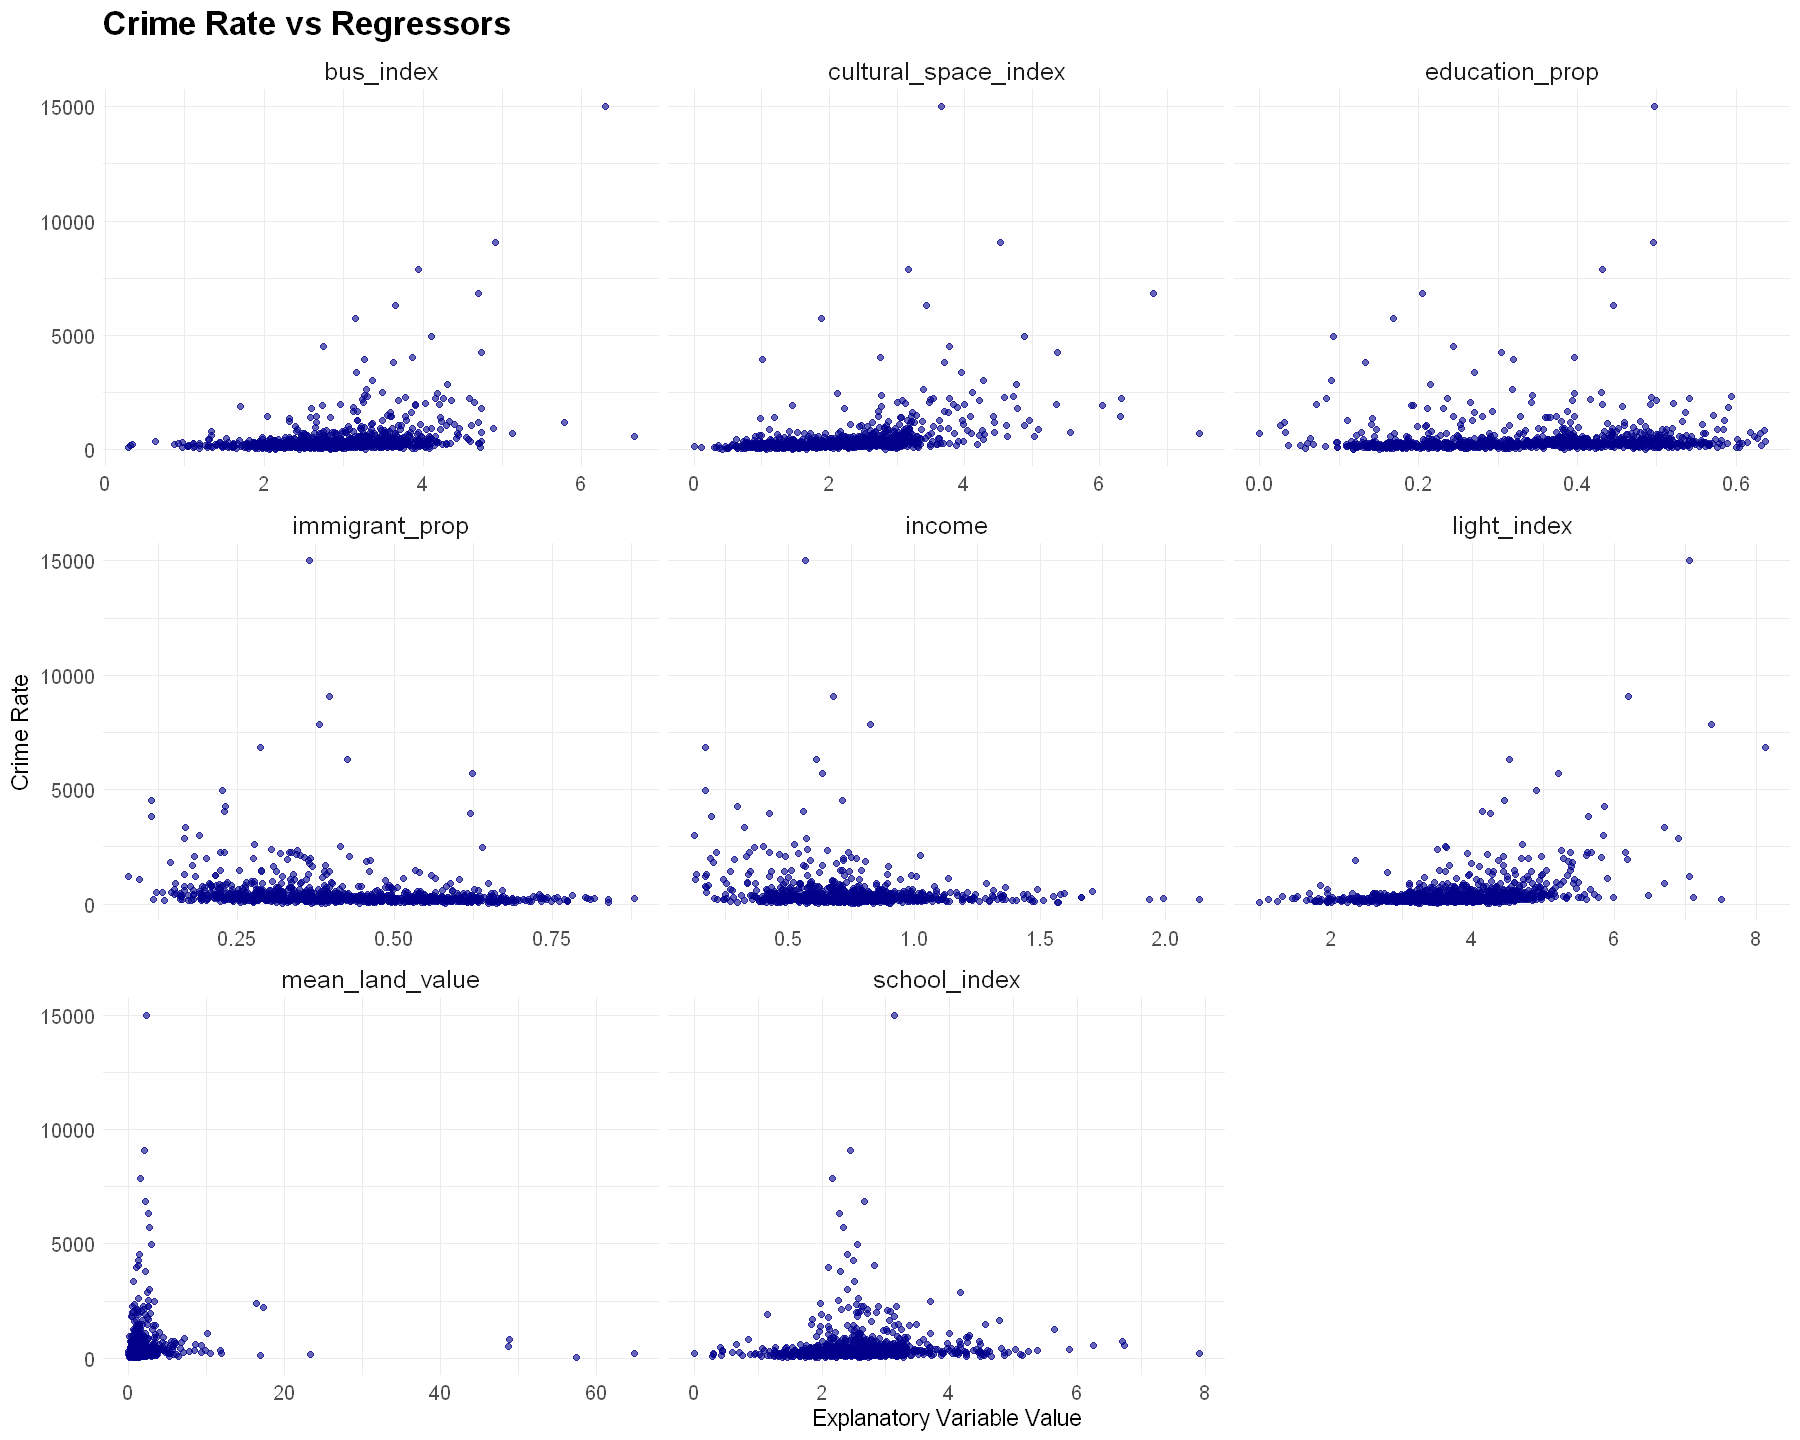

In [14]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter

By eyeball method, it's clear that the data is itself heteoskedastic.

In [15]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                                   Dependent variable:                                     
                               --------------------------------------------------------------------------------------------
                                                                        Crime Rate                                         
                                  (1)        (2)         (3)         (4)         (5)         (6)         (7)        (8)    
---------------------------------------------------------------------------------------------------------------------------
mean_land_value                  6.156                                                                                     
                                (7.024)                                                                                    
                                                                                                         

`geom_smooth()` using formula = 'y ~ x'


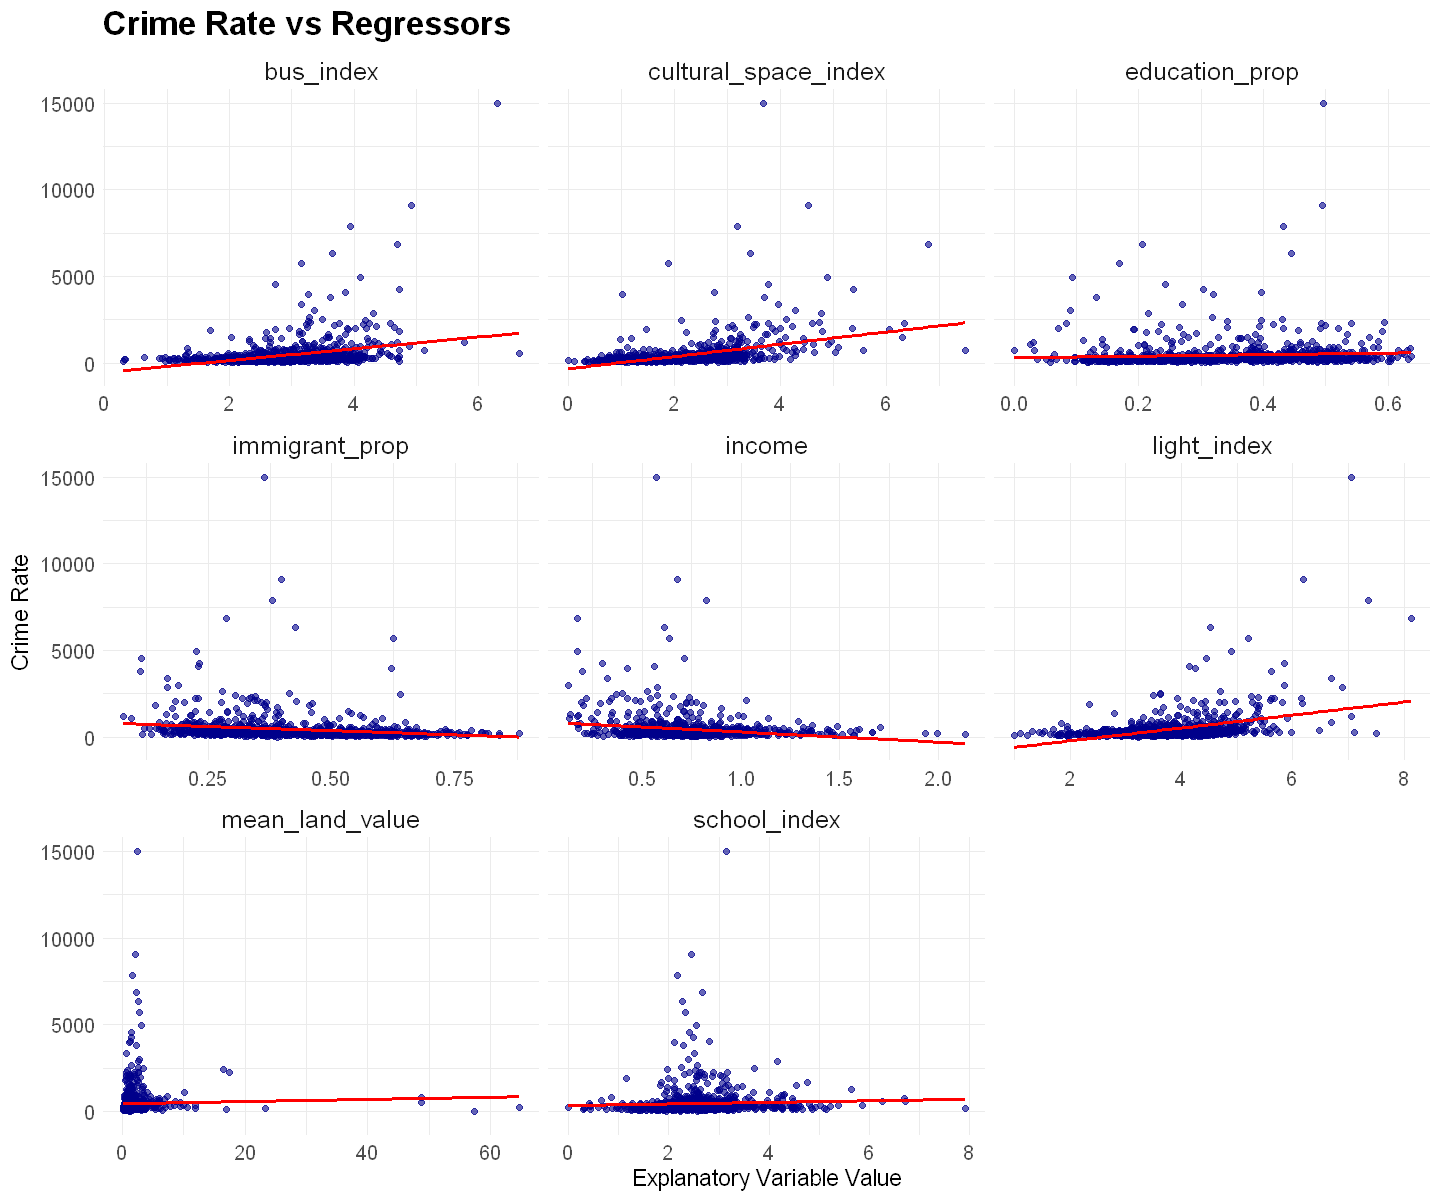

In [16]:
# Visualizing simple regressions
options(repr.plot.width = 12, repr.plot.height = 10)
simple_regression_plot <- variables_scatter +  geom_smooth(method = "lm", se = FALSE, color = "red") 

simple_regression_plot

In [17]:
# Test by running a model including all control
reg_all <- lm(crime_rate ~ mean_land_value + school_index + light_index + bus_index + cultural_space_index + 
    income + immigrant_prop + education_prop, data = census_index_crime)
    
stargazer(reg_all, type = "text",
          title = "Regression With All Variable Results",
          dep.var.labels = c("Crime Rate"))


Regression With All Variable Results
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
mean_land_value                 7.986           
                               (6.161)          
                                                
school_index                 -288.336***        
                              (36.379)          
                                                
light_index                  373.969***         
                              (46.948)          
                                                
bus_index                      27.590           
                              (51.888)          
                                                
cultural_space_index         180.362***         
                              (44.134)          
                                                
income                       -2

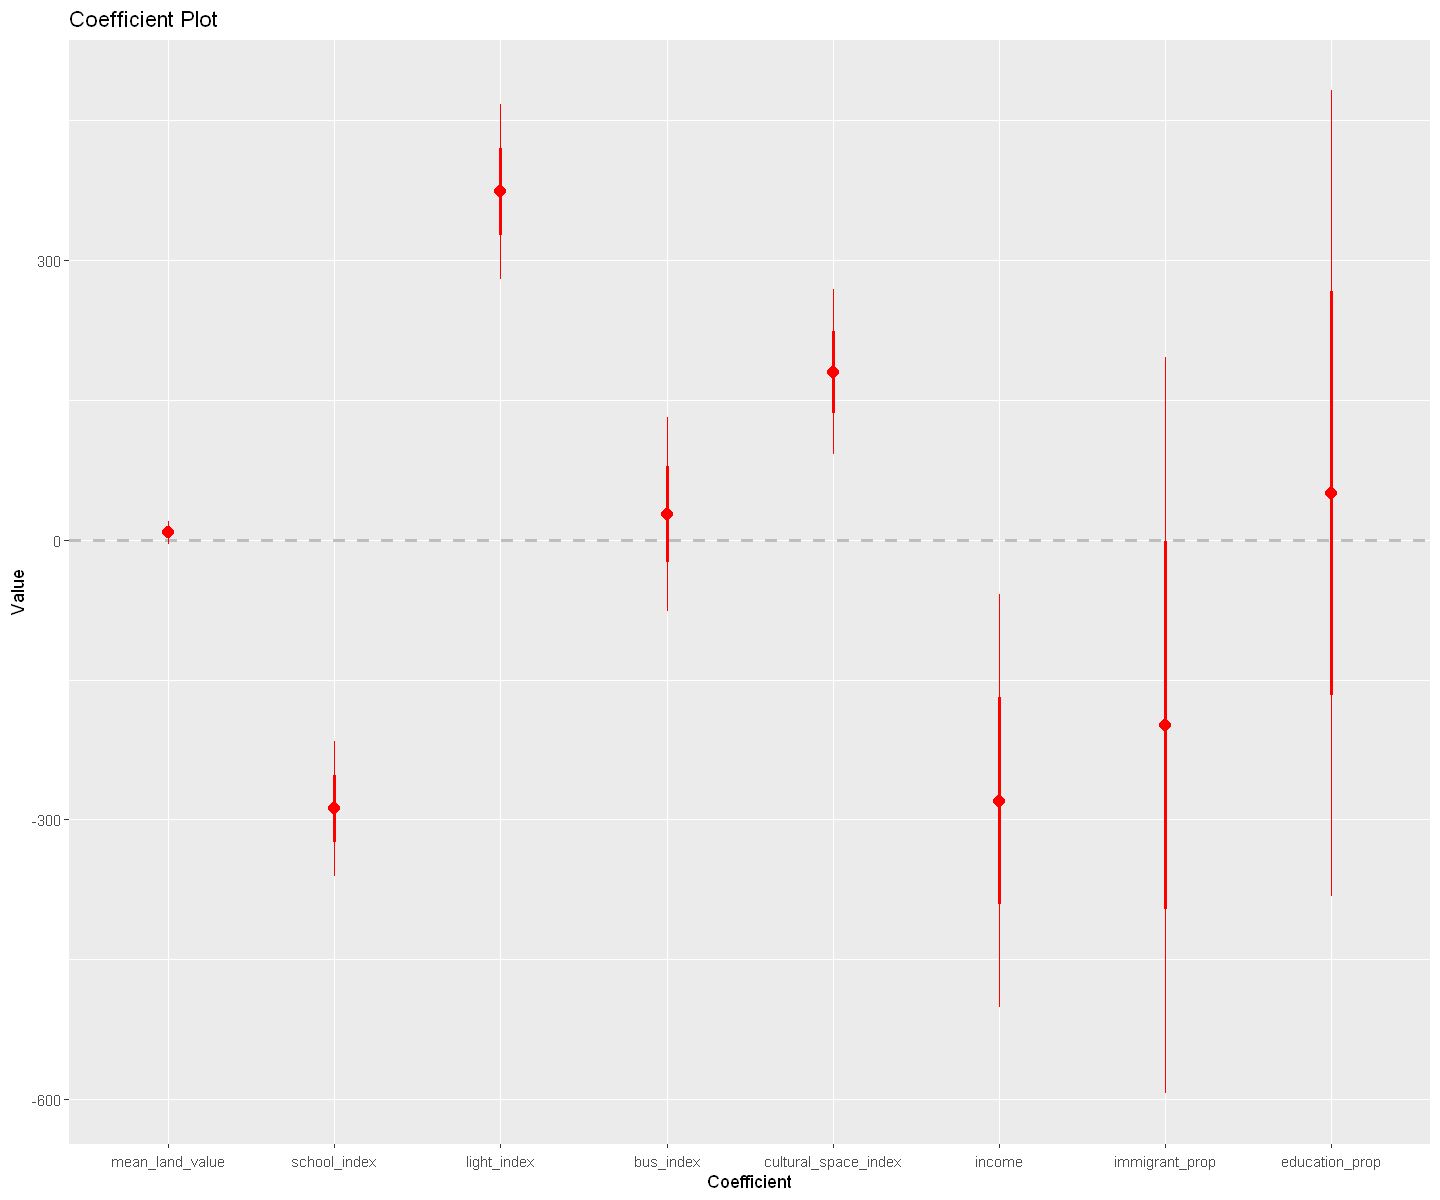

In [18]:
coefplot(reg_all, intercept = FALSE, horizontal = TRUE, color = "red")

The regression output above suggests that bus_index, immigrant_prop, and education_prop variables may be insignificant for having p-values > 0.1

In [19]:
# Examining the vif of the model
vif(reg_all, type = "terms")|>
tidy()

Warning message in tidy.numeric(vif(reg_all, type = "terms")):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
mean_land_value,1.023274
school_index,1.607963
light_index,3.238826
bus_index,3.080453
cultural_space_index,3.217783
income,1.401230
immigrant_prop,1.630053
education_prop,1.571709


In [20]:
# Predict y_hat
y_hat <- predict(reg_all)

In [21]:
# Carry out white's test
white <- lm(reg_all$residuals^2 ~ y_hat + I(y_hat^2))

stargazer(white, type = "text",
          title = "White's Test",
          dep.var.labels = c("Residual"))


White's Test
                        Dependent variable:    
                    ---------------------------
                             Residual          
-----------------------------------------------
y_hat                      -1,741.469**        
                             (734.848)         
                                               
I(y_hat2)                    3.609***          
                              (0.467)          
                                               
Constant                    -83,925.540        
                           (280,217.100)       
                                               
-----------------------------------------------
Observations                    989            
R2                             0.098           
Adjusted R2                    0.096           
Residual Std. Error  5,622,803.000 (df = 986)  
F Statistic           53.583*** (df = 2; 986)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [22]:
# Continuing on white's test
linearHypothesis(white, c("y_hat = 0", "I(y_hat^2) = 0"))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,988,3.456141e+16,NA,NA,NA,NA
2,986,3.117329e+16,2,3.388127e+15,53.58262,8.113556e-23


The extremely small p-value suggests rejecting the null hypothesis that residuals are constant.
This means there is strong evidence of heteroskedasticity in the data. We need to use robust standard errors to resolve this issue.

In [23]:
reg1 <- lm(crime_rate ~ school_index + light_index + cultural_space_index + 
    income, data = census_index_crime)

stargazer(reg1, type = "text",
          title = "Regression With Significant Controls",
          dep.var.labels = c("Crime Rate"))


Regression With Significant Controls
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -287.323***        
                              (34.776)          
                                                
light_index                  369.548***         
                              (36.862)          
                                                
cultural_space_index         217.168***         
                              (32.014)          
                                                
income                       -259.734***        
                              (97.443)          
                                                
Constant                     -479.589***        
                              (133.759)         
                                                
-------------------------------

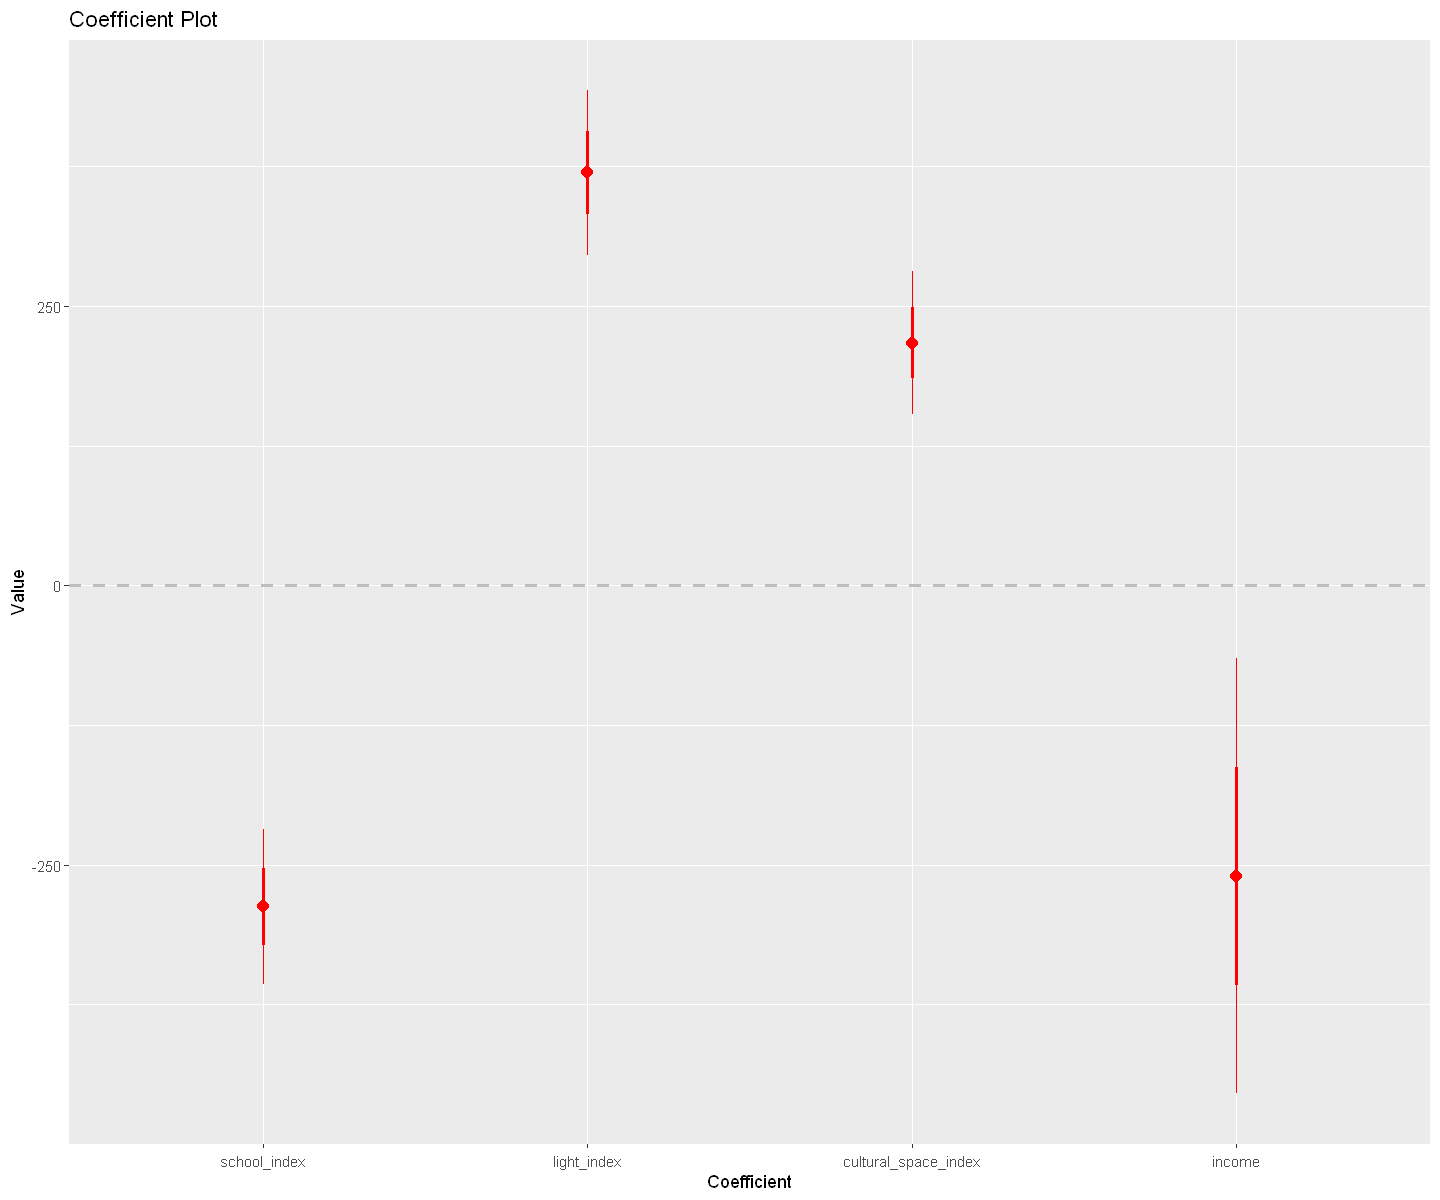

In [24]:
coefplot(reg1, intercept = FALSE, horizontal = TRUE, color = "red")

In [25]:
stargazer(simple_regressions, reg1, reg_all,
          type = "text", 
          title = "Regression Results",
          dep.var.labels = c("Crime Rate","Crime Rate"))


Regression Results
                                                                                                                               Dependent variable:                                                                                                           
                     ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                            Crime Rate                                                                                                          Crime Rate                   
                             (1)                 (2)                   (3)                      (4)                      (5)                      (6)                     (7)                    (8)                    (9

We want to make sure what made land_value and bus_index insignificant and school_index significant in our model with all variables, so we continue to run other models.

In [26]:
# Regressions with land_value always present
regressors_without_land_value <- c( 'school_index','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_land_value <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ mean_land_value +", .x)), data = census_index_crime))

names(reg_with_land_value) <- regressors

stargazer(reg_with_land_value, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                     Dependent variable:                                                                                 
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                          Crime Rate                                                                                     
                             (1)                 (2)                   (3)                     (4)                     (5)                     (6)                     (7)                   (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Regressions with school always present
regressors_without_school <- c( 'mean_land_value','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_school <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ school_index +",  .x)), data = census_index_crime))

names(reg_with_school) <- regressors

stargazer(reg_with_school, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                       Dependent variable:                                                                                  
                     ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Crime Rate                                                                                       
                             (1)                 (2)                   (3)                      (4)                     (5)                      (6)                     (7)                    (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Regressions with bus always present
regressors_without_bus <- c( 'mean_land_value','school_index','light_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_bus <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ bus_index +",  .x)), data = census_index_crime))

names(reg_with_bus) <- regressors

stargazer(reg_with_bus, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                           Dependent variable:                                                                                       
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                Crime Rate                                                                                           
                               (1)                     (2)                     (3)                     (4)                      (5)                     (6)                     (7)                     (8)          
----------------------------------------------------------------------------------------------------------------------------

From results above, we may conclude that mean land value is itself statistically insignificant, school is statistically significant when coexisting with most other variables, and bus is made insignificant by light_index (Which matched our hypothesis with visualization in fianl proposal). 

In [29]:
# Applying robust standard error to the first model
se <- sqrt(diag(vcovHC(reg_all, type = "HC1")))

stargazer(reg_all, reg_all, se = list(NULL, se), type = "text", column.labels=c("default","robust"), dep.var.labels = c("Crime Rate"))


                                   Dependent variable:     
                               ----------------------------
                                        Crime Rate         
                                  default        robust    
                                    (1)            (2)     
-----------------------------------------------------------
mean_land_value                    7.986          7.986    
                                  (6.161)        (7.369)   
                                                           
school_index                    -288.336***    -288.336*** 
                                  (36.379)      (72.917)   
                                                           
light_index                      373.969***    373.969***  
                                  (46.948)      (102.568)  
                                                           
bus_index                          27.590        27.590    
                                  (51.8


                                     Dependent variable:    
                                 ---------------------------
                                         Crime Rate         
------------------------------------------------------------
mean_land_value                             6.142           
                                           (5.605)          
                                                            
school_index                             -150.666***        
                                          (37.982)          
                                                            
education_prop                             47.402           
                                          (216.186)         
                                                            
immigrant_prop                             59.505           
                                          (205.031)         
                                                            
income                 

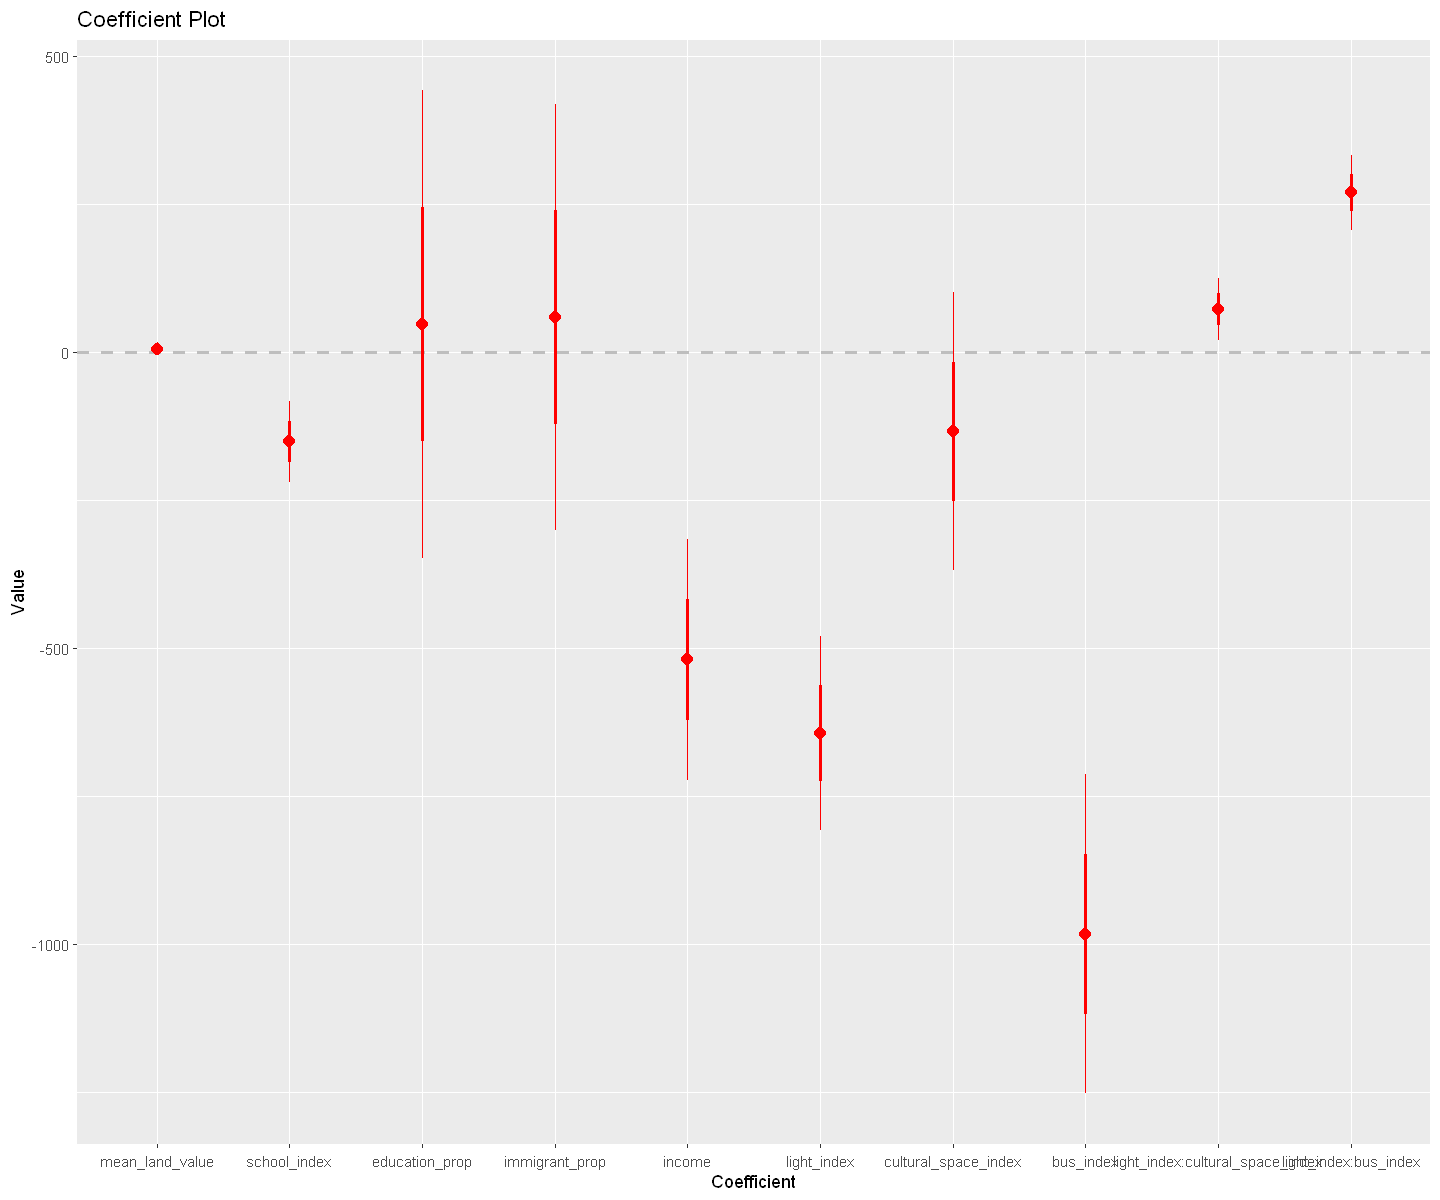

In [30]:
# Testing our specifications in final proposal, with robust standard error
reg_interaction <- lm(crime_rate ~ mean_land_value + school_index + education_prop + immigrant_prop + income + light_index
     + cultural_space_index + bus_index + light_index:cultural_space_index + light_index:bus_index, data = census_index_crime)
     
se_interaction <- sqrt(diag(vcovHC(reg_interaction, type = "HC1")))

stargazer(reg_interaction, se = list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_interaction, intercept = FALSE, horizontal = TRUE, color = "red")

Although all explanatory variables have large p-values, the model generally has a larger F statistic comparing to previous model including all variables. However the F statistic is still lower than that excluded "insignificant" controls.


                             Dependent variable:    
                         ---------------------------
                                 Crime Rate         
----------------------------------------------------
mean_land_value                     4.383           
                                   (5.605)          
                                                    
school_index                     -132.289***        
                                  (37.982)          
                                                    
education_prop                     -51.766          
                                  (216.186)         
                                                    
immigrant_prop                     35.730           
                                  (205.031)         
                                                    
income                           -489.704***        
                                  (173.470)         
                                             

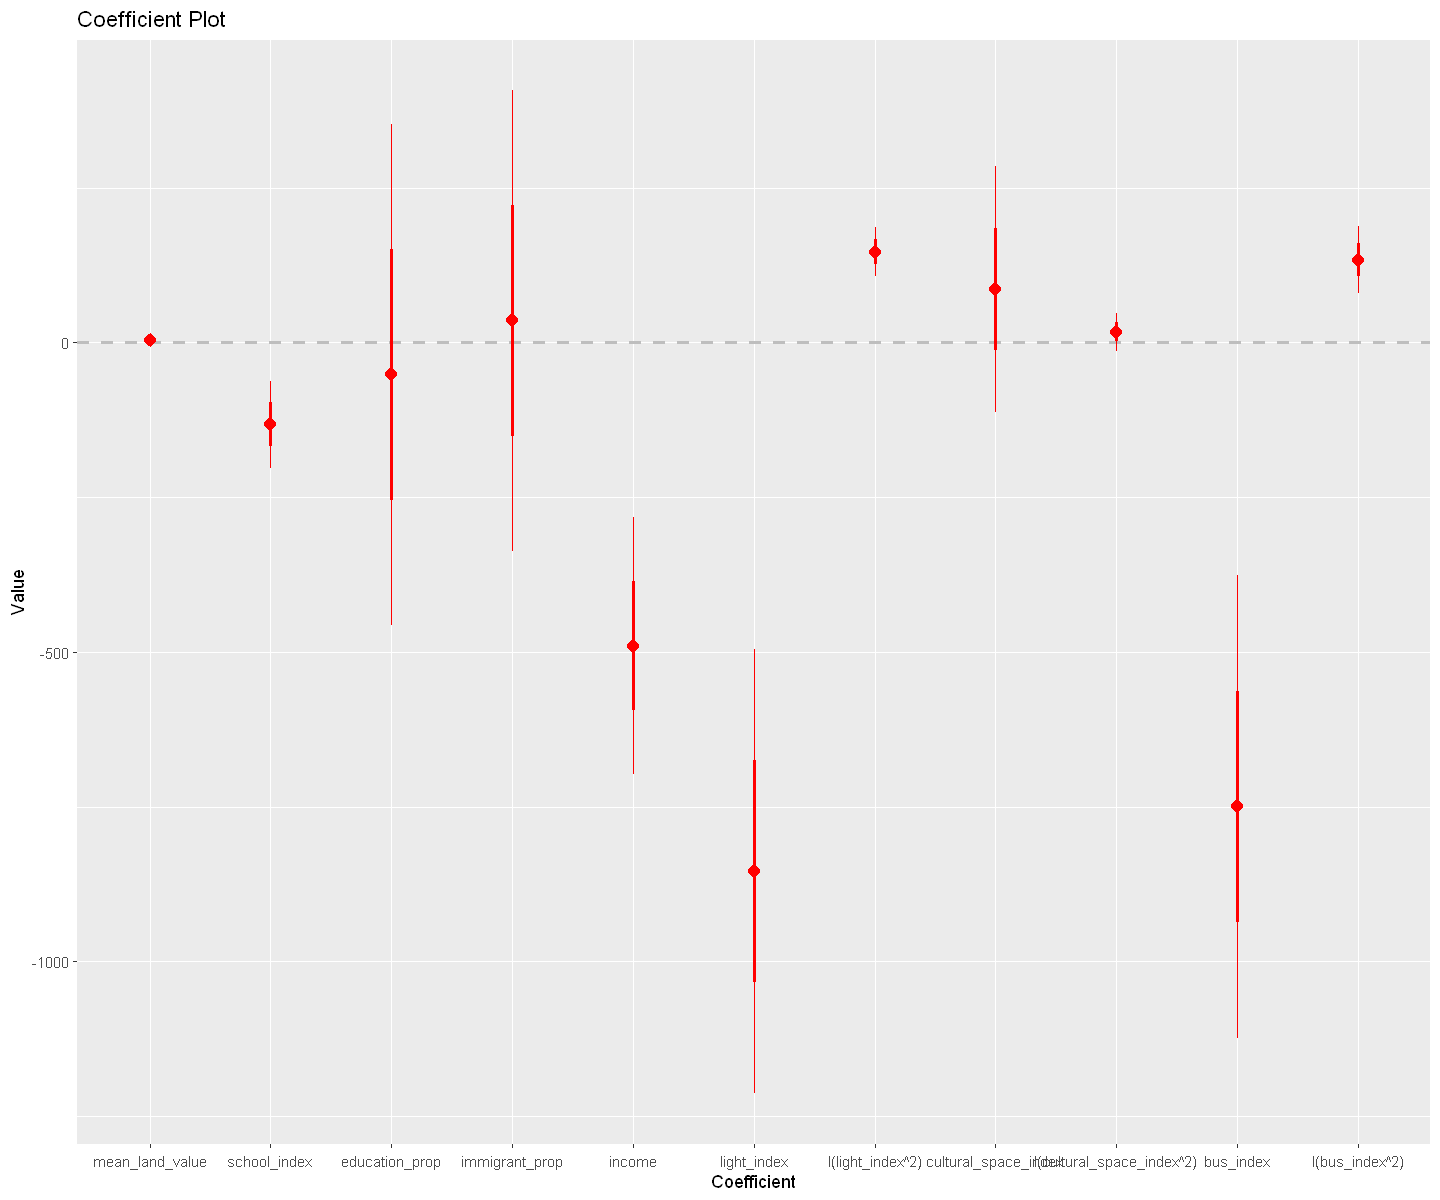

In [31]:
# Testing the specification with quadratic terms
reg_squared <- lm(crime_rate ~ mean_land_value + school_index  + education_prop + immigrant_prop + income + light_index + I(light_index^2)
     + cultural_space_index + I(cultural_space_index^2) + bus_index + I(bus_index^2), data = census_index_crime)
     
se_squared <- sqrt(diag(vcovHC(reg_squared, type = "HC1")))

stargazer(reg_squared, se =  list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_squared, intercept = FALSE, horizontal = TRUE, color = "red")

We noticed a situation that is similar to the model with interaction happened.  

In [32]:
# Show four fitted models in a single output table
se_short <- sqrt(diag(vcovHC(reg1, type = "HC1")))

stargazer(reg1, reg_all, reg_interaction, reg_squared, se = list(se_short, se, se_interaction, se_squared), 
column.labels = c("short","all", "interaction", "squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                                                        Dependent variable:                                       
                                 -------------------------------------------------------------------------------------------------
                                                                            Crime Rate                                            
                                          short                    all                 interaction                squared         
                                           (1)                     (2)                     (3)                      (4)           
----------------------------------------------------------------------------------------------------------------------------------
mean_land_value                                                   7.986                   6.142                    4.383          
                                                                 (7.369)          

In [33]:
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

se2 <- sqrt(diag(vcovHC(reg2, type = "HC1")))
se3 <- sqrt(diag(vcovHC(reg3, type = "HC1")))

stargazer(reg2, reg3, se = list(se2, se3), 
column.labels = c("log","squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                 Dependent variable:             
                     --------------------------------------------
                                      Crime Rate                 
                              log                  squared       
                              (1)                    (2)         
-----------------------------------------------------------------
log(mean_land_value)       112.032***                            
                            (33.057)                             
                                                                 
mean_land_value                                   50.625***      
                                                  (16.419)       
                                                                 
I(mean_land_value2)                               -0.904***      
                                                   (0.285)       
                                                                 
Constant 

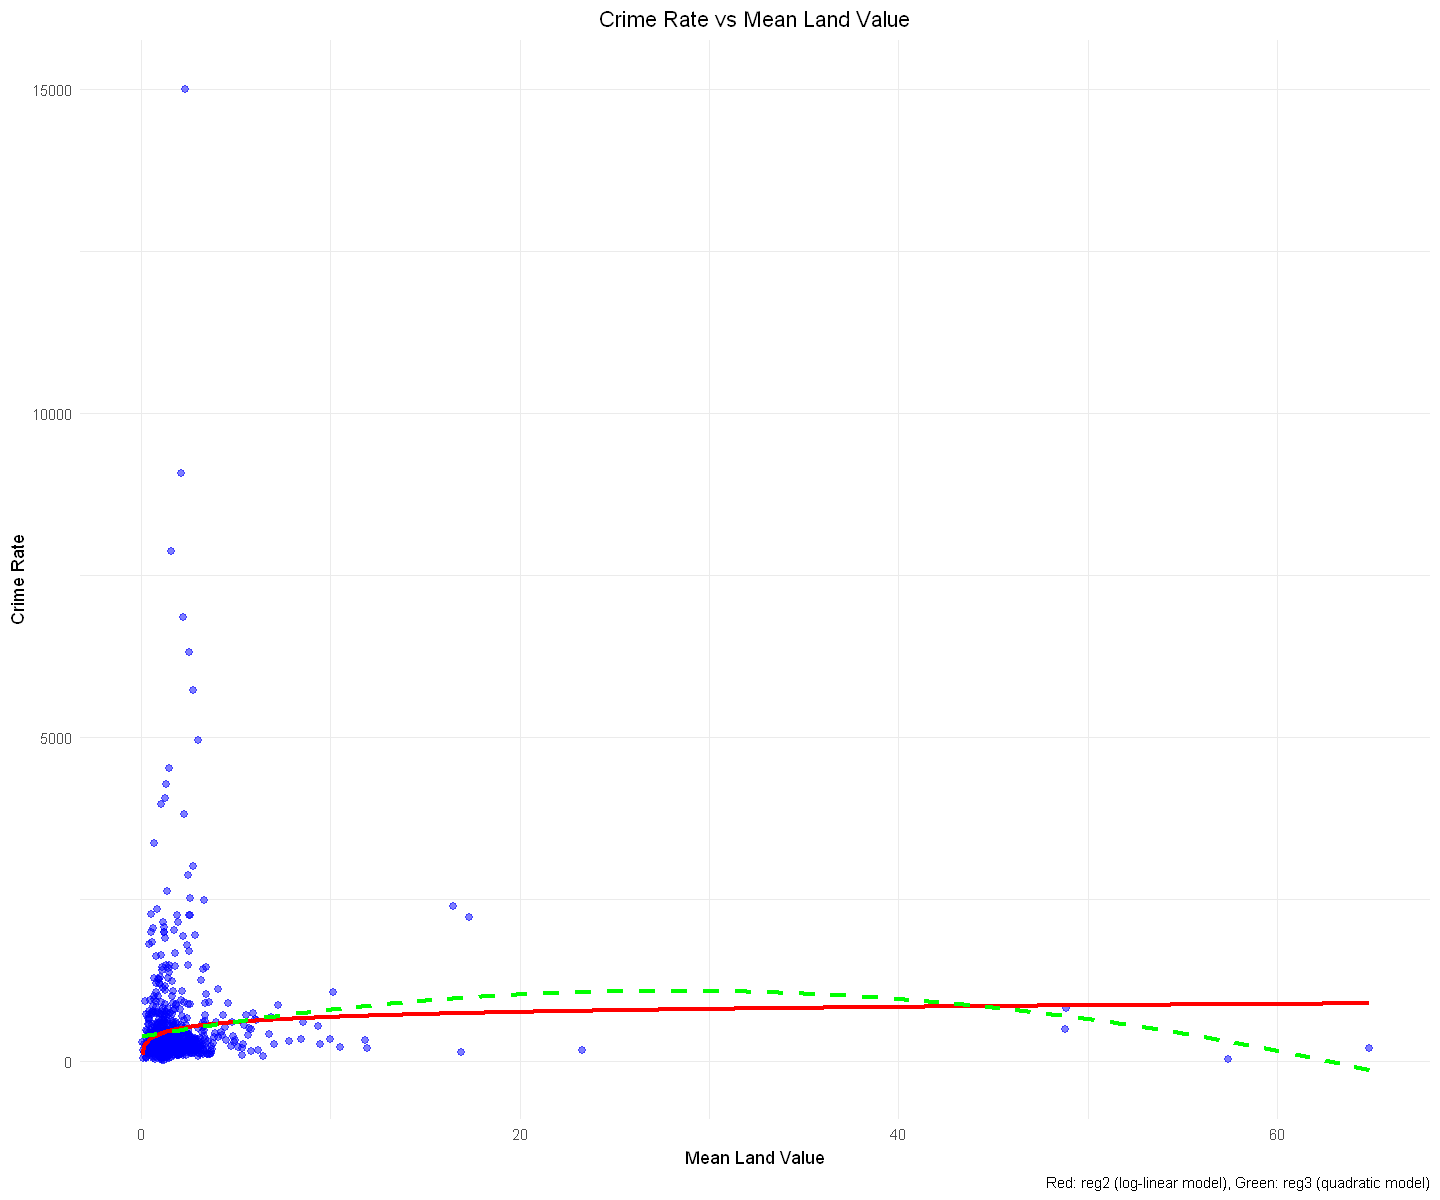

In [34]:
# Create a new data frame for predictions
census_index_crime$pred_reg2 <- predict(reg2)  # Predictions from reg2
census_index_crime$pred_reg3 <- predict(reg3)  # Predictions from reg3

# Generate a sequence of `mean_land_value` for smoother curves
land_value_seq <- seq(min(census_index_crime$mean_land_value), max(census_index_crime$mean_land_value), length.out = 500)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "Red: reg2 (log-linear model), Green: reg3 (quadratic model)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0183 -0.4950 -0.0921  0.3787  3.8691 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63816    0.02848 197.954  < 2e-16 ***
log(mean_land_value)  0.12702    0.03737   3.399 0.000704 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01157,	Adjusted R-squared:  0.01057 
F-statistic: 11.55 on 1 and 987 DF,  p-value: 0.0007044


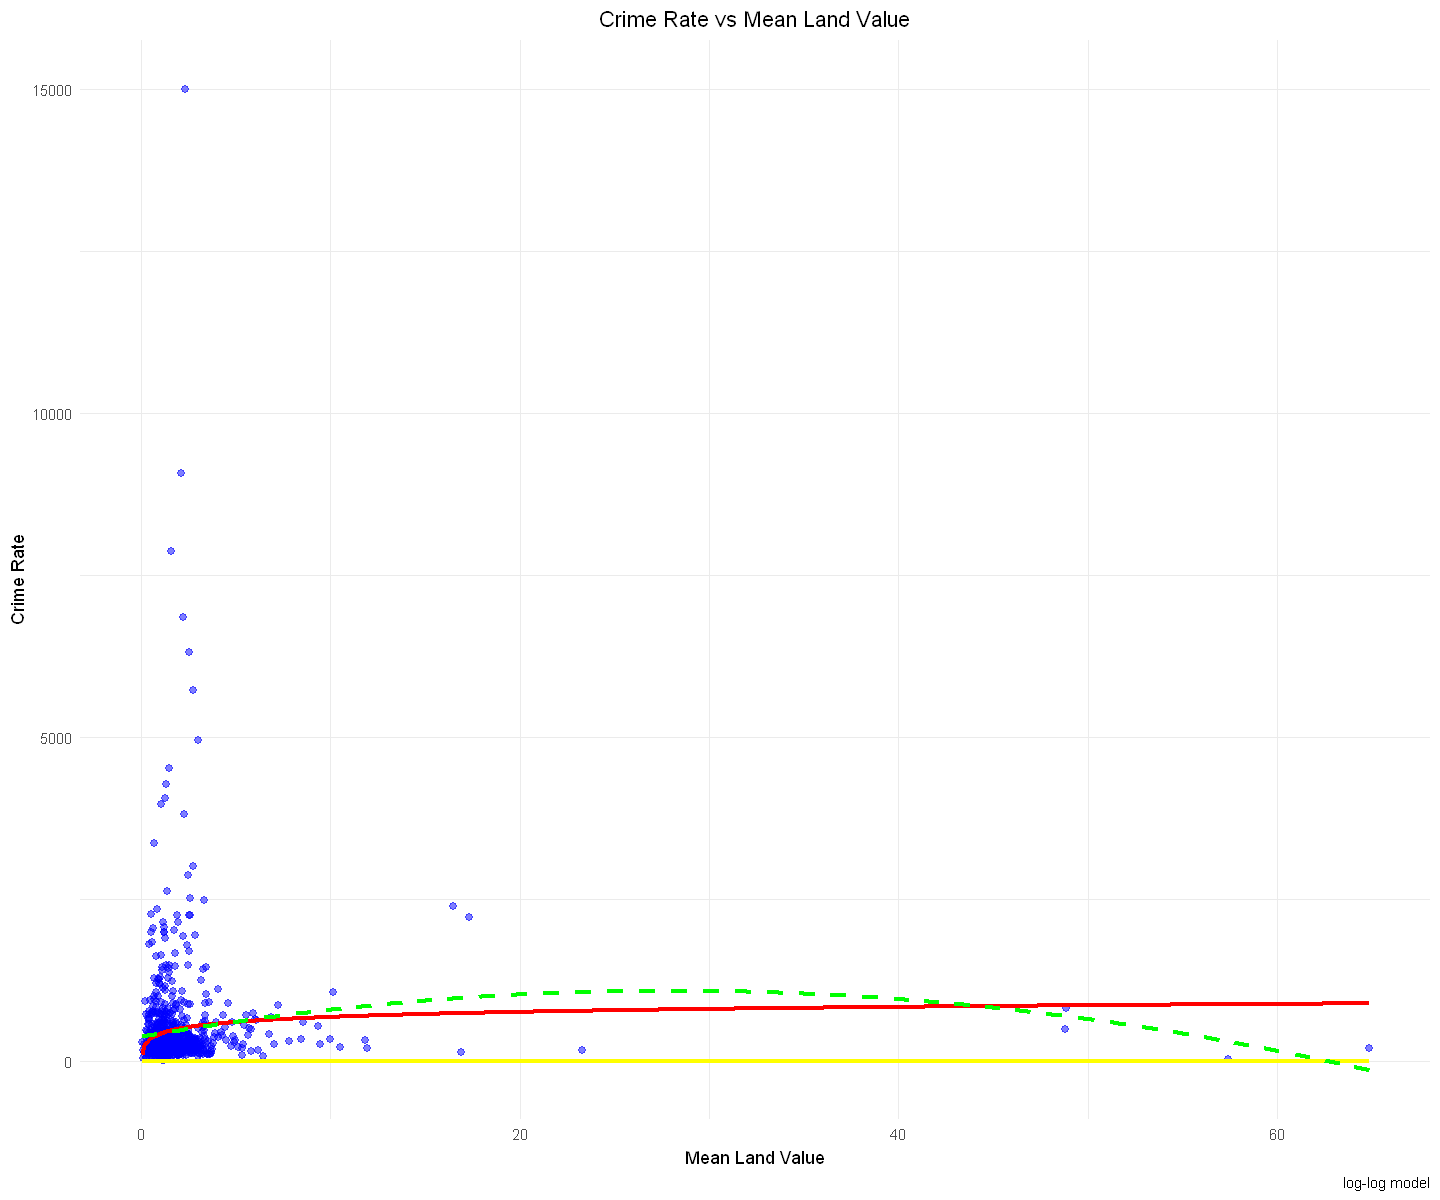

In [35]:
reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
    pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "log-log model"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))



Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0183 -0.4950 -0.0921  0.3787  3.8691 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63816    0.02848 197.954  < 2e-16 ***
log(mean_land_value)  0.12702    0.03737   3.399 0.000704 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01157,	Adjusted R-squared:  0.01057 
F-statistic: 11.55 on 1 and 987 DF,  p-value: 0.0007044



Call:
lm(formula = crime_rate ~ mean_land_value + I(mean_land_value^2), 
    data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
 -904.0  -275.5  -185.6   -30.7 14507.3 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          378.7202    40.8893   9.262  < 2e-16 ***
mean_land_value       50.6250    19.0437   2.658  0.00798 ** 
I(mean_land_value^2)  -0.9041     0.3601  -2.511  0.01219 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 839.8 on 986 degrees of freedom
Multiple R-squared:  0.007128,	Adjusted R-squared:  0.005114 
F-statistic: 3.539 on 2 and 986 DF,  p-value: 0.02941


Warning message in log(pred_reg3):
"NaNs produced"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."


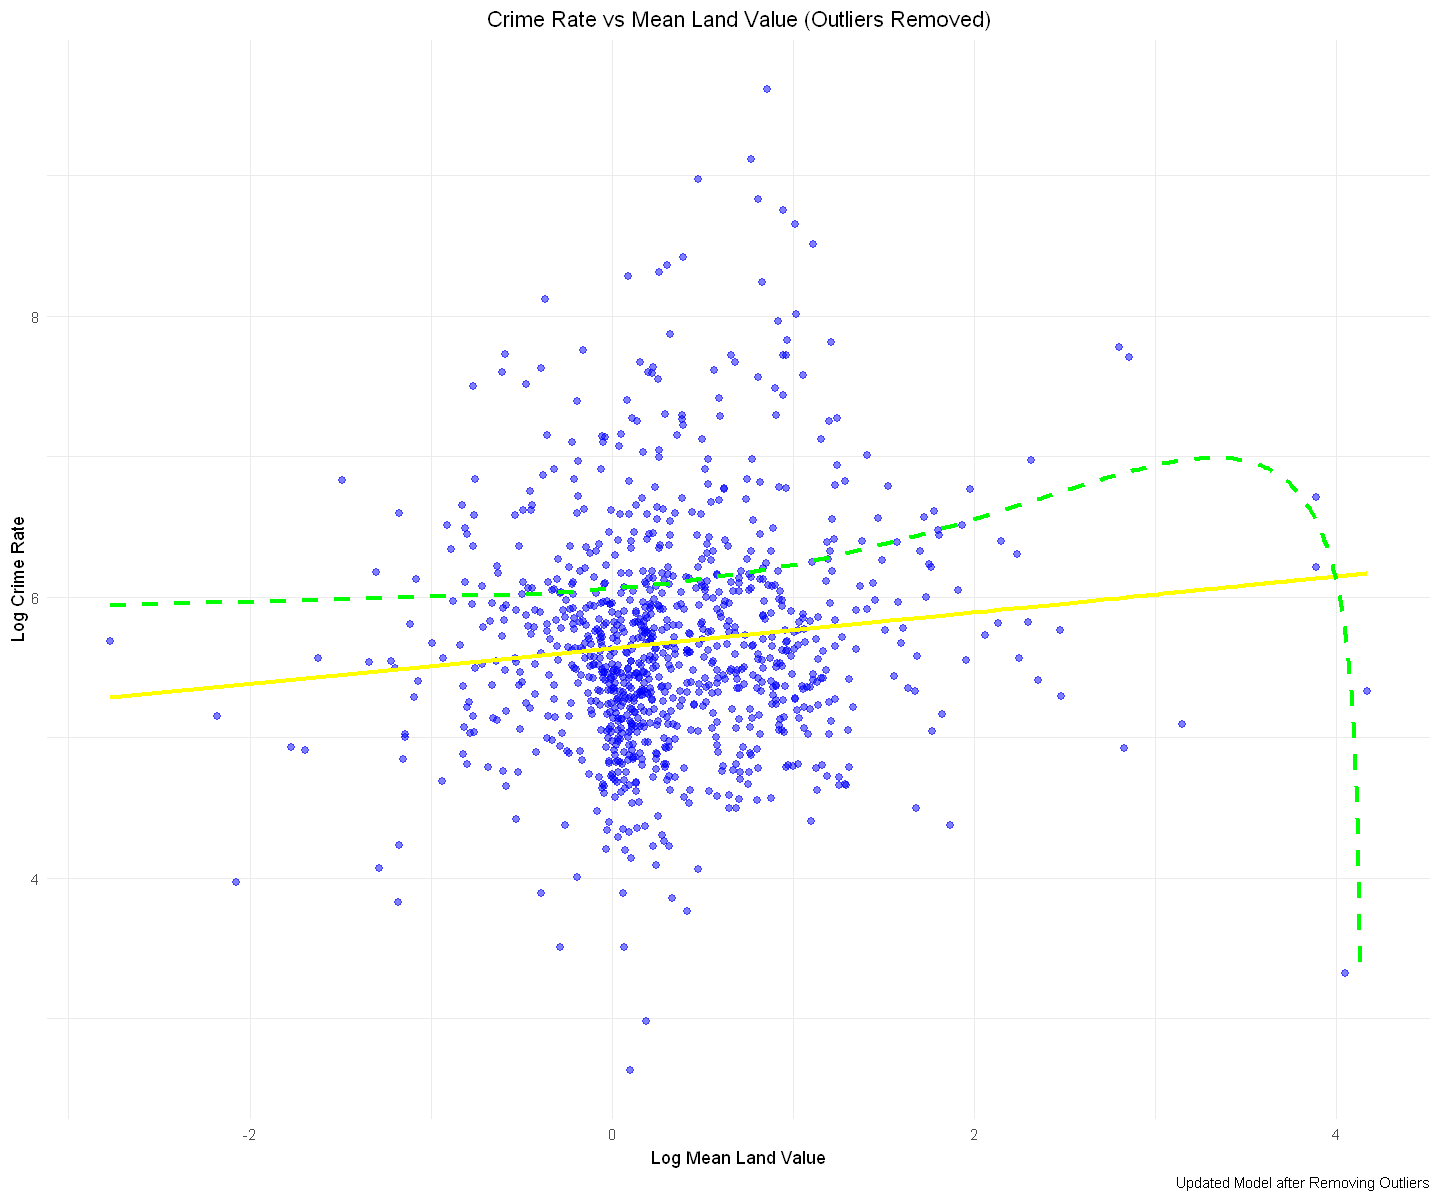

In [36]:
# census_index_crime <- census_index_crime %>%
#   arrange(desc(mean_land_value)) %>% 
#   slice(-1:-4)                     


reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)
summary(reg3)

land_value_seq <- seq(min(census_index_crime$mean_land_value), 
                      max(census_index_crime$mean_land_value), length.out = 100)

smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

ggplot(census_index_crime, aes(x = log(mean_land_value), y = log(crime_rate))) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + 
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = log(pred_reg3)), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value (Outliers Removed)",
    x = "Log Mean Land Value",
    y = "Log Crime Rate",
    caption = "Updated Model after Removing Outliers"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


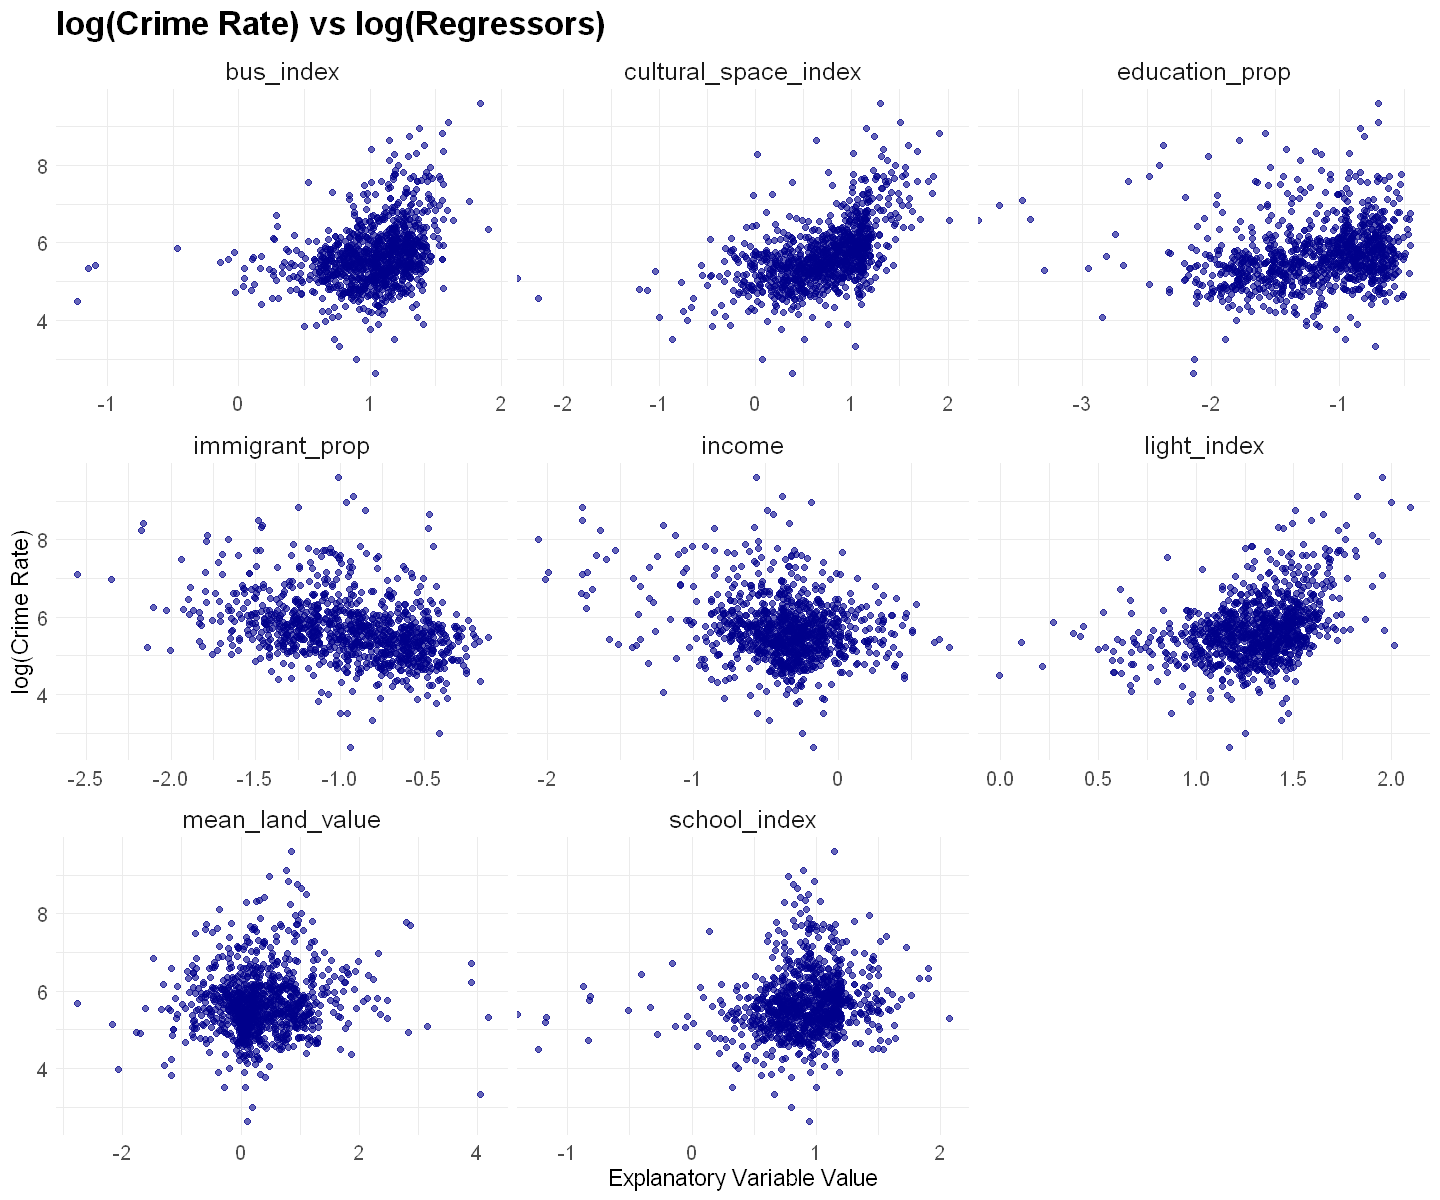

In [37]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = log(value), y = log(crime_rate))) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [38]:
# Identify variables with zeros
zero_counts <- sapply(census_index_crime, function(x) {
  if (is.numeric(x)) {
    sum(x == 0, na.rm = TRUE)
  } else {
    NA
  }
})
print("Variables with zero counts:")
print(zero_counts)

[1] "Variables with zero counts:"
                name           households            dwellings 
                  NA                    0                    0 
          population   population_density               region 
                   0                    0                   NA 
          area_sq_km                  age               income 
                   0                    0                    0 
      immigrant_prop       education_prop         school_index 
                   0                    1                    1 
         light_index            bus_index cultural_space_index 
                   0                    0                    1 
         crime_count           crime_rate      mean_land_value 
                   0                    0                    0 
            geometry            pred_reg2            pred_reg3 
                  NA                    0                    0 
           pred_reg4 
                   0 


In [39]:
# Replace 0 with a small constant for log_cultural_space_index and remove log transformation for immigrant_prop and education_prop
census_index_crime <- census_index_crime %>% 
  mutate(
    log_crime_rate = log(crime_rate),
    log_mean_land_value = log(mean_land_value),
    log_school_index = log(ifelse(school_index == 0, 0.000001, school_index)),
    log_light_index = log(light_index),
    log_bus_index = log(bus_index),
    log_cultural_space_index = log(ifelse(cultural_space_index == 0, 0.000001, cultural_space_index)),
    log_income = log(income),
    immigrant_prop = immigrant_prop,  # No log transformation
    education_prop = education_prop   # No log transformation
  )

In [40]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_bus_index
                + log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime)

# Display summary of the model
summary(reg_log)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log, ~ fitted(reg_log) + I(fitted(reg_log)^2), data = census_index_crime)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust <- coeftest(reg_log, vcov = vcovHC(reg_log, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust)
} else {
  print("No significant heteroskedasticity detected.")
}

# Generate a regression table with stargazer
stargazer(reg_log, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"))

if (exists("reg_log_robust")) {
  stargazer(reg_log, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(vcovHC(reg_log, type = "HC1")))
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_bus_index + log_cultural_space_index + 
    log_income + immigrant_prop + education_prop, data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4251 -0.3795 -0.0287  0.3434  2.7826 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               3.90945    0.17213  22.712  < 2e-16 ***
log_mean_land_value       0.16611    0.03099   5.361 1.03e-07 ***
log_school_index         -0.16348    0.04453  -3.672 0.000254 ***
log_light_index           1.32412    0.15005   8.825  < 2e-16 ***
log_bus_index            -0.03463    0.13129  -0.264 0.792028    
log_cultural_space_index  0.09224    0.04106   2.246 0.024900 *  
log_income               -0.56102    0.06538  -8.581  < 2e-16 ***
immigrant_prop           -1.14232    0.16063  -7.112 2.21e-12 ***
education_prop            1.11944    0.18637   6.007 2.67e-09 ***
---
Signi


	studentized Breusch-Pagan test

data:  reg_log
BP = 59.788, df = 2, p-value = 1.041e-13

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               3.909451   0.206516 18.9305 < 2.2e-16 ***
log_mean_land_value       0.166109   0.042195  3.9367 8.844e-05 ***
log_school_index         -0.163479   0.087058 -1.8778    0.0607 .  
log_light_index           1.324122   0.199783  6.6278 5.616e-11 ***
log_bus_index            -0.034627   0.146117 -0.2370    0.8127    
log_cultural_space_index  0.092240   0.097852  0.9426    0.3461    
log_income               -0.561025   0.072396 -7.7493 2.303e-14 ***
immigrant_prop           -1.142324   0.181844 -6.2819 5.022e-10 ***
education_prop            1.119438   0.218061  5.1336 3.427e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent var

In [41]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log2 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + 
                 log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime)

# Display summary of the model
summary(reg_log2)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log2, ~ fitted(reg_log2) + I(fitted(reg_log2)^2), data = census_index_crime)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust2 <- coeftest(reg_log2, vcov = vcovHC(reg_log2, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust2)
} else {
  print("No significant heteroskedasticity detected.")
}

# Generate a regression table with stargazer
stargazer(reg_log2, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"))

if (exists("reg_log_robust")) {
  stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(vcovHC(reg_log2, type = "HC1")))
}



Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_cultural_space_index + log_income + 
    immigrant_prop + education_prop, data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4164 -0.3762 -0.0350  0.3442  2.7872 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               3.91604    0.17023  23.004  < 2e-16 ***
log_mean_land_value       0.16721    0.03069   5.449 6.42e-08 ***
log_school_index         -0.16769    0.04154  -4.037 5.83e-05 ***
log_light_index           1.29630    0.10666  12.153  < 2e-16 ***
log_cultural_space_index  0.09080    0.04068   2.232   0.0258 *  
log_income               -0.55760    0.06405  -8.706  < 2e-16 ***
immigrant_prop           -1.14232    0.16055  -7.115 2.16e-12 ***
education_prop            1.11879    0.18626   6.007 2.67e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error


	studentized Breusch-Pagan test

data:  reg_log2
BP = 60.169, df = 2, p-value = 8.6e-14

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               3.916040   0.205171 19.0867 < 2.2e-16 ***
log_mean_land_value       0.167210   0.042323  3.9508 8.346e-05 ***
log_school_index         -0.167694   0.084498 -1.9846   0.04747 *  
log_light_index           1.296301   0.167208  7.7526 2.245e-14 ***
log_cultural_space_index  0.090803   0.096684  0.9392   0.34788    
log_income               -0.557597   0.072428 -7.6986 3.348e-14 ***
immigrant_prop           -1.142316   0.181589 -6.2907 4.754e-10 ***
education_prop            1.118791   0.217960  5.1330 3.437e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent variable:    
                         ---------------------------
     

In [42]:
  stargazer(reg_log, reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(vcovHC(reg_log, type = "HC1")))


Log-Log Regression Results with Robust Errors
                                       Dependent variable:              
                         -----------------------------------------------
                                         Log Crime Rate                 
                                   (1)                     (2)          
------------------------------------------------------------------------
log_mean_land_value             0.166***                0.167***        
                                (-0.002)                 (0.031)        
                                                                        
log_school_index                -0.163***               -0.168***       
                                 (0.001)                 (0.042)        
                                                                        
log_light_index                 1.324***                1.296***        
                                (-0.027)                 (0.107)        
    

In [43]:
 stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(vcovHC(reg_log, type = "HC1")))


Log-Log Regression Results with Robust Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value               0.167***          
                                  (-0.002)          
                                                    
log_school_index                  -0.168***         
                                   (0.001)          
                                                    
log_light_index                   1.296***          
                                  (-0.027)          
                                                    
log_cultural_space_index          0.091***          
                                   (0.003)          
                                                    
log_income                        -0.558***         
                                   (0.007)          

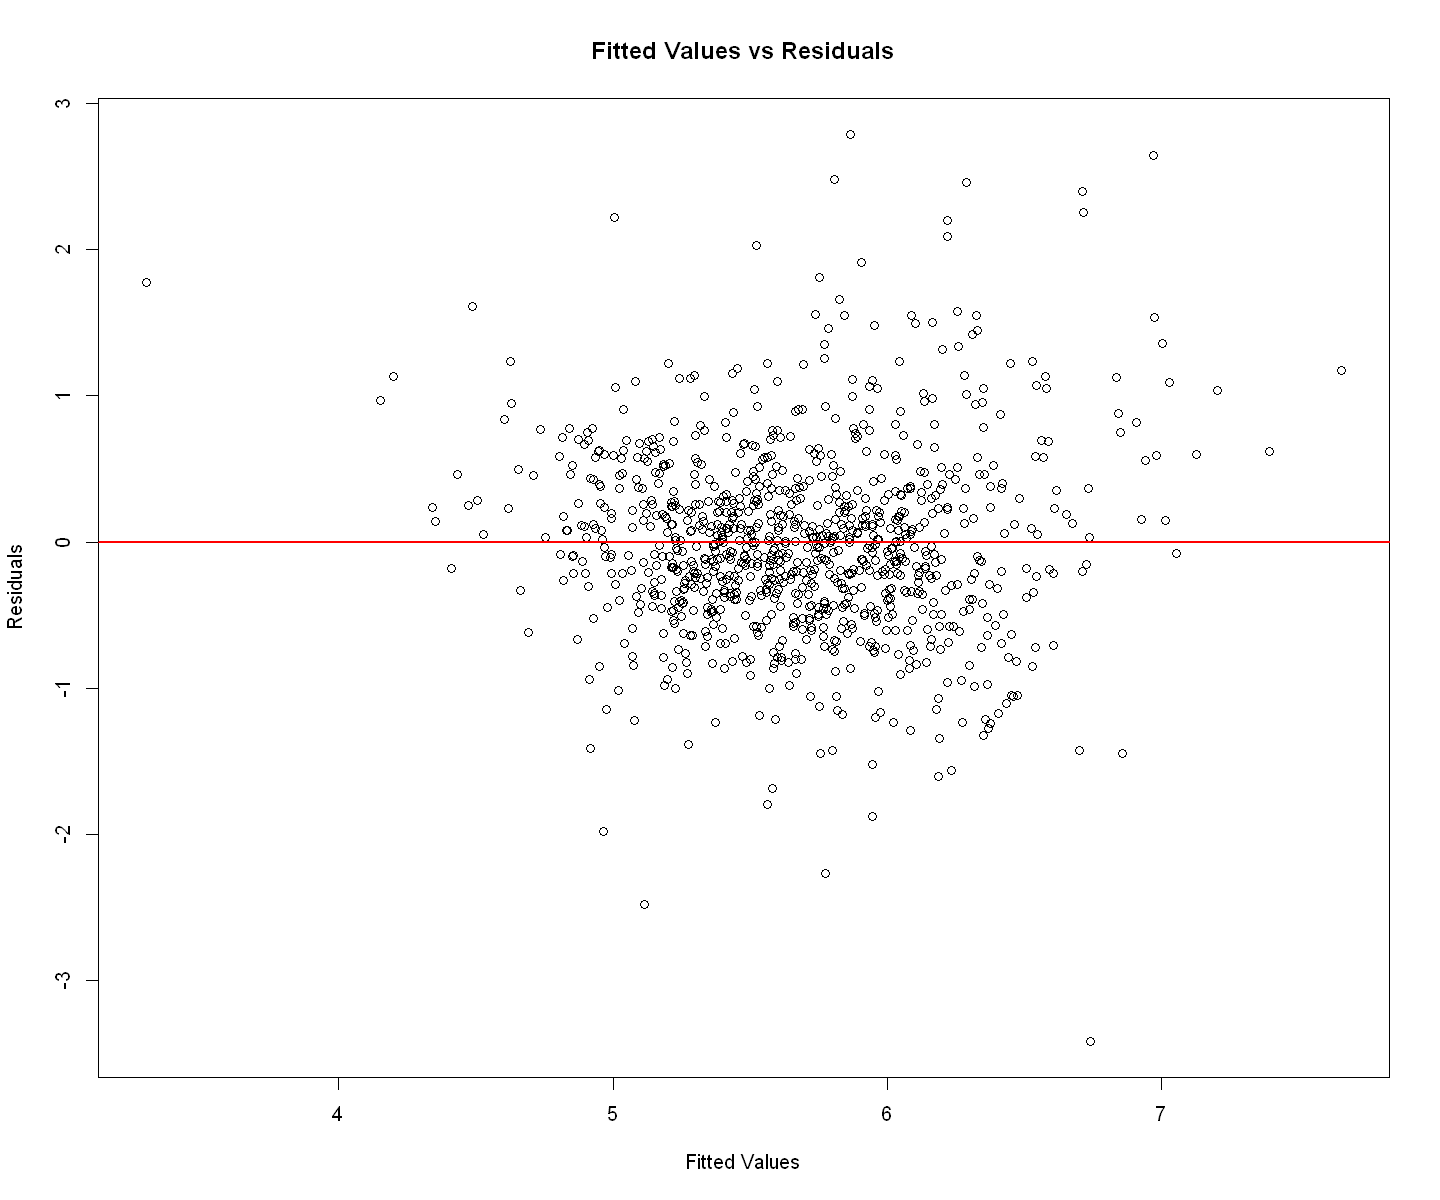

In [44]:
# Plot fitted values vs residuals
plot(fitted(reg_log2), residuals(reg_log2), 
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Fitted Values vs Residuals")

# Add a horizontal line at 0 to assess heteroskedasticity
abline(h = 0, col = "red", lwd = 2)


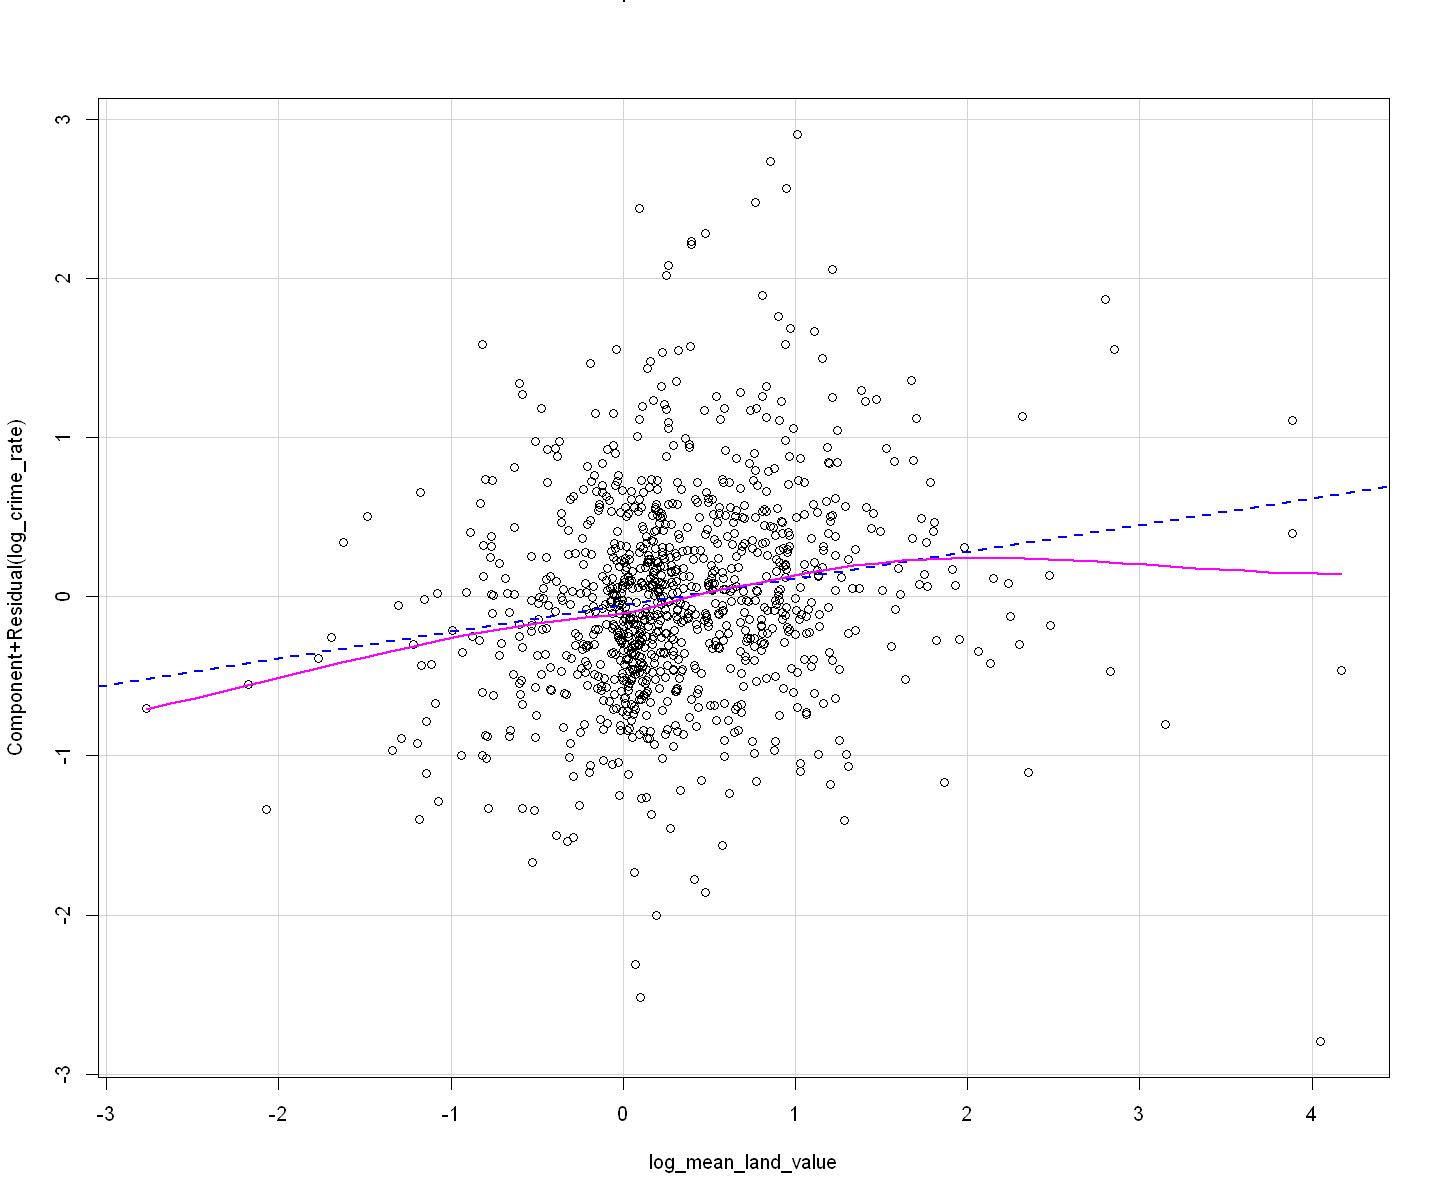

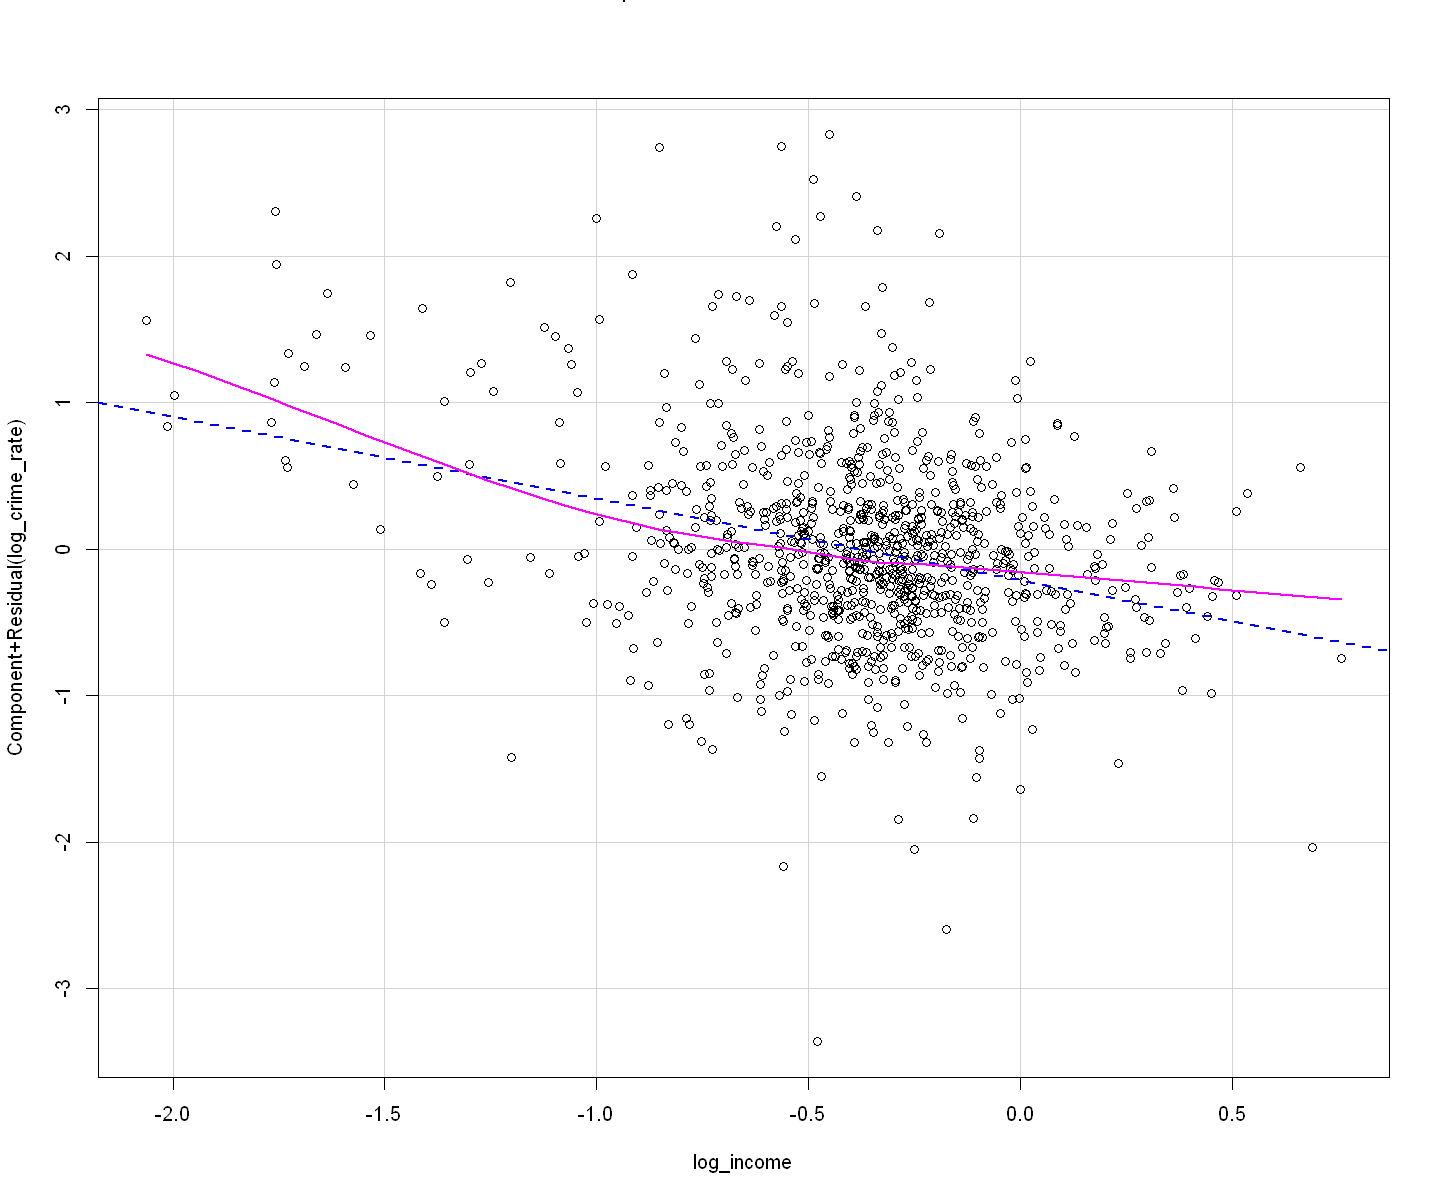

In [46]:
# Partial regression plot for log_mean_land_value
crPlots(reg_log2, terms = ~ log_mean_land_value)

# Partial regression plot for log_income
crPlots(reg_log2, terms = ~ log_income)